# HAM w/ iStructTab

In [1]:
# ============================ QUIET LOGS ============================
import os, warnings
warnings.filterwarnings("ignore", message=r"Deterministic behavior.*")
warnings.filterwarnings("ignore", message=r".*does not have a deterministic implementation.*")
warnings.filterwarnings("ignore", category=UserWarning, module="torch")
os.environ.pop("CUBLAS_WORKSPACE_CONFIG", None)

# ============================ IMPORTS ===============================
from pathlib import Path
import numpy as np
import pandas as pd
from PIL import Image

import torch
from torch.utils.data import Dataset, DataLoader, random_split, Subset
import torchvision.transforms as T
from torch import optim
import optuna

# Your model (GEDS + OEMT + Linformer)
from iStructTab import iStructTab, set_seed

# ============================ USER PATHS ============================
CSV_PATH = "HAM10000_metadata_labeled.csv"  # in current working directory
IMG_ROOT = "ham_images_link"                # must contain ISIC_*.jpg images

# ============================ DEVICE PICKER (cuda:2) ================
def pick_device(force_idx=2):
    if torch.cuda.is_available():
        if force_idx < torch.cuda.device_count():
            torch.cuda.set_device(force_idx)
            return torch.device(f"cuda:{force_idx}")
        torch.cuda.set_device(0)
        return torch.device("cuda:0")
    return torch.device("cpu")

set_seed(123)
device = pick_device()
print("Device:", device)

# ============================ DATASET + COLLATE =====================
# ------------------- DATASET -------------------
class HamDataset(Dataset):
    """HAM10000 multimodal dataset (dx = target)."""
    def __init__(self, csv_path, img_root, transform=None):
        df = pd.read_csv(csv_path)
        self.img_root = Path(img_root)
        self.transform = transform

        assert "image_id" in df.columns and "dx" in df.columns

        # Remove `label` column if exists
        if "label" in df.columns:
            df = df.drop(columns=["label"])

        # Encode dx → label
        classes = sorted(df["dx"].astype(str).unique())
        mapping = {c: i for i, c in enumerate(classes)}
        df["label"] = df["dx"].map(mapping)
        self.classes = classes

        # Keep only valid images
        paths, keep_idx = [], []
        for i, row in df.iterrows():
            name = str(row["image_id"])
            p = self.img_root / (name if name.endswith(".jpg") else f"{name}.jpg")
            if p.exists():
                keep_idx.append(i)
                paths.append(p)
        df = df.iloc[keep_idx].reset_index(drop=True)
        self.img_paths = paths
        self.df = df

        # Split columns into numeric / categorical
        exclude = {"image_id", "dx", "label"}
        num_cols, cat_cols = [], []
        for col in df.columns:
            if col in exclude:
                continue
            if pd.api.types.is_numeric_dtype(df[col]):
                num_cols.append(col)
            else:
                cat_cols.append(col)
        self.num_cols, self.cat_cols = num_cols, cat_cols
        self.text_cols = []

        # Numeric tensor
        if num_cols:
            num_df = df[num_cols].astype(float).fillna(0.0)
            self.x_num = torch.tensor(num_df.to_numpy(copy=True), dtype=torch.float32)
        else:
            self.x_num = torch.zeros((len(df), 0), dtype=torch.float32)

        # Categorical tensor
        self.x_cat = None
        if cat_cols:
            cat_arrays = []
            for col in cat_cols:
                vals = df[col].astype(str)
                uniq = sorted(vals.unique())
                vocab = {v: i for i, v in enumerate(uniq)}
                ids = [vocab[v] for v in vals]
                cat_arrays.append(torch.tensor(ids, dtype=torch.long))
            self.x_cat = torch.stack(cat_arrays, dim=1)

        # Dummy text channel so EmbeddingBag never sees O_text=0
        self.x_text = torch.zeros((len(df), 1, 1), dtype=torch.long)

        # Target
        self.y = torch.tensor(df["label"].values, dtype=torch.long)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img = Image.open(self.img_paths[idx]).convert("RGB")
        if self.transform:
            img = self.transform(img)

        x_tab = {
            "num": self.x_num[idx].unsqueeze(0),
            "cat": self.x_cat[idx].unsqueeze(0) if self.x_cat is not None else torch.zeros((1, 0), dtype=torch.long),
            "text": self.x_text[idx].unsqueeze(0),
        }
        return x_tab, img, self.y[idx]

def collate(batch):
    x_tab_b, x_img_b, y_b = zip(*batch)
    x_num_b = torch.cat([b["num"] for b in x_tab_b], dim=0)
    if x_tab_b[0]["cat"].numel():
        x_cat_b = torch.cat([b["cat"] for b in x_tab_b], dim=0)
    else:
        x_cat_b = torch.zeros((len(x_tab_b), 0), dtype=torch.long)
    x_text_b = torch.cat([b["text"] for b in x_tab_b], dim=0)
    x_tab_batch = {"num": x_num_b, "cat": x_cat_b, "text": x_text_b}
    x_img_b = torch.stack(x_img_b)
    y_b = torch.tensor(y_b)
    return x_tab_batch, x_img_b, y_b

def accuracy_from_logits(logits, y):
    return (logits.argmax(dim=1) == y).float().mean().item()

# ========================== DATA & LOADERS ==========================
transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225])  # ImageNet
])

ds = HamDataset(CSV_PATH, IMG_ROOT, transform=transform)

n_classes = len(ds.classes)
N = len(ds)
n_train = int(round(0.64 * N))
n_val   = int(round(0.16 * N))
n_test  = N - n_train - n_val
assert n_train > 0 and n_val > 0 and n_test > 0, f"Bad split sizes (N={N})."

g = torch.Generator().manual_seed(123)
ds_train, ds_val, ds_test = random_split(ds, [n_train, n_val, n_test], generator=g)

def make_loaders(batch_size):
    pin = device.type == "cuda"
    dl_train = DataLoader(
        ds_train,
        batch_size=batch_size,
        shuffle=True,
        num_workers=0,
        pin_memory=pin,
        collate_fn=collate,
    )
    dl_val = DataLoader(
        ds_val,
        batch_size=batch_size,
        shuffle=False,
        num_workers=0,
        pin_memory=pin,
        collate_fn=collate,
    )
    dl_test = DataLoader(
        ds_test,
        batch_size=batch_size,
        shuffle=False,
        num_workers=0,
        pin_memory=pin,
        collate_fn=collate,
    )
    return dl_train, dl_val, dl_test

# token hint = numeric + categorical + (dummy) text(=1)
NUM_TAB_FEATURES = len(ds.num_cols) + len(ds.cat_cols) + 1

# ============================ MODEL BUILDING ========================
def build_model(params):
    model = iStructTab(
        num_tab_features=NUM_TAB_FEATURES,
        num_classes=n_classes,
        d_model=params["d_model"],
        # OEMT + Linformer hyperparams
        oemt_heads=params["oemt_heads"],
        oemt_layers=params["oemt_layers"],
        oemt_k=params["oemt_k"],
        linformer_k=params["linformer_k"],
        # loss weight
        lambda_fs=params["lambda_fs"],
        # encoders
        pretrained_resnet=True,
        img_in_channels=3,
    ).to(device)
    return model

def run_epoch(model, loader, opt=None):
    train = opt is not None
    model.train(train)
    losses, accs = [], []
    for x_tab, img, y in loader:
        img, y = img.to(device), y.to(device)
        x_tab = {k: v.to(device) for k, v in x_tab.items()}
        out = model(x_tab, img, y=y)
        if train:
            opt.zero_grad()
            out["loss"].backward()
            opt.step()
        losses.append(out["loss"].item())
        accs.append(accuracy_from_logits(out["logits"], y))
    return (float(np.mean(losses)) if losses else 0.0,
            float(np.mean(accs))   if accs   else 0.0)

# ================================ OPTUNA ============================
PENALIZE_LAMBDA = 0.02      # objective = val_acc - PENALIZE_LAMBDA * lambda_fs
EPOCHS_TUNE     = 3         # quick per-trial epochs
FINAL_EPOCHS    = 25        # final fit on train+val
N_TRIALS        = 20

def suggest_params(trial):
    return {
        # ensure d_model % oemt_heads == 0
        "d_model": trial.suggest_categorical("d_model", [128, 192, 256]),
        "oemt_heads": trial.suggest_categorical("oemt_heads", [2, 4, 8]),
        "oemt_layers": trial.suggest_int("oemt_layers", 1, 3),
        "oemt_k": trial.suggest_categorical("oemt_k", [32, 64, 128]),
        "linformer_k": trial.suggest_categorical("linformer_k", [16, 32, 64]),

        # Optim
        "lr": trial.suggest_float("lr", 1e-4, 4e-4, log=True),
        "weight_decay": trial.suggest_float("weight_decay", 1e-6, 2e-4, log=True),
        "batch_size": trial.suggest_categorical("batch_size", [8, 16, 32]),

        # feature-sequencing loss
        "lambda_fs": trial.suggest_float("lambda_fs", 0.0, 0.3),
    }

def objective(trial):
    params = suggest_params(trial)
    # guard to avoid Linformer / OEMT assertion
    if params["d_model"] % params["oemt_heads"] != 0:
        raise optuna.TrialPruned()

    set_seed(1000 + trial.number)
    dl_train, dl_val, _ = make_loaders(params["batch_size"])

    model = build_model(params)
    opti  = optim.AdamW(model.parameters(), lr=params["lr"], weight_decay=params["weight_decay"])

    # warmup (optional)
    try:
        x_tab_b, img_b, y_b = next(iter(dl_train))
        img_b, y_b = img_b.to(device), y_b.to(device)
        x_tab_b = {k: v.to(device) for k, v in x_tab_b.items()}
        _ = model(x_tab_b, img_b, y=y_b)
    except StopIteration:
        pass

    for _ in range(EPOCHS_TUNE):
        run_epoch(model, dl_train, opt=opti)

    _, val_acc = run_epoch(model, dl_val, opt=None)
    score = float(val_acc - PENALIZE_LAMBDA * params["lambda_fs"])
    return score

study = optuna.create_study(
    direction="maximize",
    sampler=optuna.samplers.TPESampler(seed=123),
)
study.optimize(
    objective,
    n_trials=N_TRIALS,
    gc_after_trial=True,
    show_progress_bar=True,
)

best = study.best_trial.params

# ==================== RETRAIN BEST + TEST EVAL ======================
set_seed(777)
dl_train_best, dl_val_best, dl_test_best = make_loaders(best["batch_size"])

# Merge train+val (use original indices from random_split)
trainval_indices = ds_train.indices + ds_val.indices
subset = Subset(ds, trainval_indices)

pin = device.type == "cuda"
dl_trainval = DataLoader(
    subset,
    batch_size=best["batch_size"],
    shuffle=True,
    num_workers=0,
    pin_memory=pin,
    collate_fn=collate,
)

model_best = build_model(best)
opt_best   = optim.AdamW(
    model_best.parameters(),
    lr=best["lr"],
    weight_decay=best["weight_decay"],
)

# warmup once (optional)
try:
    x_tab_b, img_b, y_b = next(iter(dl_trainval))
    img_b, y_b = img_b.to(device), y_b.to(device)
    x_tab_b = {k: v.to(device) for k, v in x_tab_b.items()}
    _ = model_best(x_tab_b, img_b, y=y_b)
except StopIteration:
    pass

for _ in range(FINAL_EPOCHS):
    run_epoch(model_best, dl_trainval, opt=opt_best)

test_loss, test_acc = run_epoch(model_best, dl_test_best, opt=None)

print("\n=== FINAL TEST RESULTS (HAM + iStructTab) ===")
print(f"Test accuracy: {test_acc:.4f}")
print(f"Test loss:     {test_loss:.4f}")

print("\n=== Best config (used for validation & test) ===")
for k, v in best.items():
    print(f"  {k}: {v}")
print("\nClasses:", ds.classes)

Device: cuda:2


[I 2025-12-08 17:38:34,174] A new study created in memory with name: no-name-245b2659-99f7-41d1-be7a-4cad7b51846b


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2025-12-08 18:19:12,975] Trial 0 finished with value: 0.6572584529509787 and parameters: {'d_model': 128, 'oemt_heads': 4, 'oemt_layers': 3, 'oemt_k': 32, 'linformer_k': 32, 'lr': 0.00010862497110096086, 'weight_decay': 8.239707046432085e-06, 'batch_size': 8, 'lambda_fs': 0.1594654121525515}. Best is trial 0 with value: 0.6572584529509787.
[I 2025-12-08 19:34:33,608] Trial 1 finished with value: 0.7329975081585521 and parameters: {'d_model': 256, 'oemt_heads': 2, 'oemt_layers': 1, 'oemt_k': 32, 'linformer_k': 16, 'lr': 0.00018172104749476022, 'weight_decay': 1.3676791243895849e-05, 'batch_size': 32, 'lambda_fs': 0.26801674893514044}. Best is trial 1 with value: 0.7329975081585521.
[I 2025-12-08 20:55:19,677] Trial 2 finished with value: 0.7126719960870856 and parameters: {'d_model': 128, 'oemt_heads': 8, 'oemt_layers': 3, 'oemt_k': 128, 'linformer_k': 32, 'lr': 0.00031441751808227667, 'weight_decay': 2.4415152689902066e-05, 'batch_size': 8, 'lambda_fs': 0.12510666330741047}. Best is

In [2]:
import torch

model_best.eval()

total_params = sum(p.numel() for p in model_best.parameters())
params_m = total_params / 1e6
print(f"Params_M (millions) ≈ {params_m:.2f} M")
print(f"Total parameters     = {total_params:,}")

Params_M (millions) ≈ 28.10 M
Total parameters     = 28,096,653


In [5]:
import torch.nn as nn
from ptflops import get_model_complexity_info

# Wrap iStructTab to look like a plain image→logits model for ptflops
class IStructTabWrapper(nn.Module):
    def __init__(self, model, num_num, num_cat):
        super().__init__()
        self.model = model
        self.num_num = num_num
        self.num_cat = num_cat

    def forward(self, x_img):
        B = x_img.size(0)
        x_tab = {
            "num": torch.zeros(B, self.num_num, device=x_img.device),
            "cat": torch.zeros(B, self.num_cat, dtype=torch.long, device=x_img.device),
            "text": torch.zeros(B, 1, 1, dtype=torch.long, device=x_img.device),
        }
        out = self.model(x_tab, x_img)
        return out["logits"]

wrapper = IStructTabWrapper(
    model_best,
    num_num=len(ds.num_cols),
    num_cat=len(ds.cat_cols),
).to(device)
wrapper.eval()

with torch.no_grad():
    macs, params = get_model_complexity_info(
        wrapper,
        (3, 224, 224),   # same as HAM transform
        as_strings=False,
        print_per_layer_stat=False,
        verbose=False,
    )

flops_g = (2 * macs) / 1e9  # MACs → FLOPs (approx 2 ops per MAC)
print(f"FLOPs_G ≈ {flops_g:.2f} GFLOPs per image")

FLOPs_G ≈ 8.43 GFLOPs per image


In [4]:
!pip install -q ptflops

In [6]:
# Grab one batch from the HAM test loader
batch = next(iter(dl_test_best))
x_tab_b, img_b, y_b = batch
img_b = img_b.to(device)
x_tab_b = {k: v.to(device) for k, v in x_tab_b.items()}

model_best.eval()
torch.cuda.reset_peak_memory_stats(device)

with torch.no_grad():
    _ = model_best(x_tab_b, img_b)

torch.cuda.synchronize()
peak_bytes = torch.cuda.max_memory_allocated(device)
peak_gb = peak_bytes / (1024 ** 3)
print(f"PeakMem_GB ≈ {peak_gb:.2f} GB (for batch size = {img_b.size(0)})")

PeakMem_GB ≈ 0.80 GB (for batch size = 32)


In [7]:
import time

model_best.eval()

batch = next(iter(dl_test_best))
x_tab_b, img_b, y_b = batch
img_b = img_b.to(device)
x_tab_b = {k: v.to(device) for k, v in x_tab_b.items()}
B = img_b.size(0)

# Warm-up
with torch.no_grad():
    for _ in range(5):
        _ = model_best(x_tab_b, img_b)

torch.cuda.synchronize()
runs = 30
start = time.time()
with torch.no_grad():
    for _ in range(runs):
        _ = model_best(x_tab_b, img_b)
torch.cuda.synchronize()
end = time.time()

total_images = runs * B
infer_ms = (end - start) * 1000.0 / total_images
print(f"Infer_ms ≈ {infer_ms:.3f} ms per image (batch size = {B})")

Infer_ms ≈ 1.149 ms per image (batch size = 32)


In [8]:
import time

# (Rebuild a fresh model & optimizer, or reuse model_best if you want to actually re-train)
model_tt = build_model(best)
opt_tt = optim.AdamW(
    model_tt.parameters(),
    lr=best["lr"],
    weight_decay=best["weight_decay"],
)

model_tt.train()
torch.cuda.synchronize()
start = time.time()
run_epoch(model_tt, dl_trainval, opt=opt_tt)
torch.cuda.synchronize()
end = time.time()

epoch_sec = end - start
FINAL_EPOCHS = 25
total_sec = epoch_sec * FINAL_EPOCHS
train_time_h = total_sec / 3600.0
print(f"Approx TrainTime_h ≈ {train_time_h:.2f} hours "
      f"(based on 1 epoch × {FINAL_EPOCHS})")

Approx TrainTime_h ≈ 0.72 hours (based on 1 epoch × 25)


# t-SNE

Embeddings shape: (2003, 384) | Labels shape: (2003,)


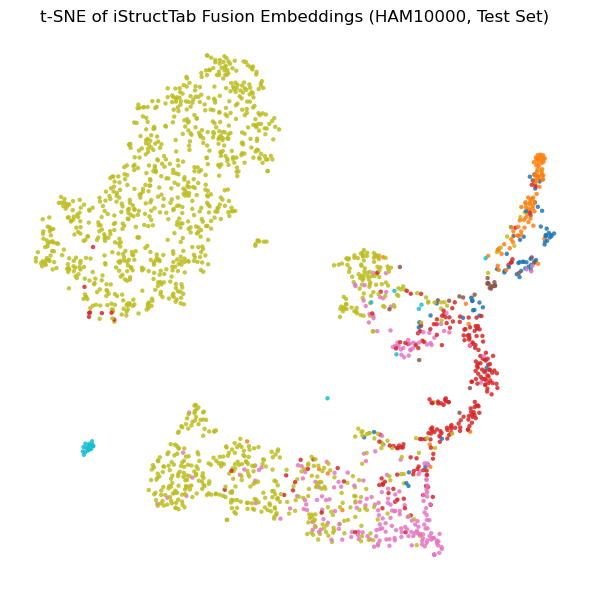

In [9]:
# ============================================================
# t-SNE Visualization for iStructTab (HAM10000, test set)
#  - Uses model_best, ds_test, dl_test_best already defined
# ============================================================
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

model_best.eval()
all_embs, all_labels = [], []

with torch.no_grad():
    for x_tab, x_img, y in dl_test_best:
        x_img = x_img.to(device)
        x_tab = {k: v.to(device) for k, v in x_tab.items()}
        y = y.to(device)

        # --- Get fused multimodal representation BEFORE GEDS/OEMT ---
        tab_vec = model_best.tab_enc(x_tab)   # (B, d_model)
        img_vec = model_best.img_enc(x_img)   # (B, d_model)
        fused   = torch.cat([tab_vec, img_vec], dim=1)  # (B, 2*d_model)

        all_embs.append(fused.cpu().numpy())
        all_labels.append(y.cpu().numpy())

embs = np.vstack(all_embs)
labels = np.concatenate(all_labels)
print("Embeddings shape:", embs.shape, "| Labels shape:", labels.shape)

# ------------------- t-SNE -------------------
tsne = TSNE(
    n_components=2,
    perplexity=35,
    learning_rate=200,
    random_state=42,
    init="pca",
)
Z = tsne.fit_transform(embs)

plt.figure(figsize=(6, 6))
scatter = plt.scatter(
    Z[:, 0], Z[:, 1],
    c=labels,
    cmap="tab10",
    s=10,
    alpha=0.85,
    edgecolors="none"
)
plt.axis("off")
plt.title("t-SNE of iStructTab Fusion Embeddings (HAM10000, Test Set)")
plt.tight_layout()
plt.savefig("tsne_ham10000_istructtab_test.png", dpi=600, bbox_inches="tight")
plt.savefig("tsne_ham10000_istructtab_test.pdf", bbox_inches="tight")
plt.show()

# Inference Level Ablation on Calibration and Robustness

[INFO] Using iStructTab HAM model on device=cuda:2
[INFO] Test batches: 63

=== HAM10000 + iStructTab Ablation Summary ===
      Tab Shuffle ↓  Tab Drop ↓  Img Blur σ  kNN-Agree@5
0.00          85.17       85.17         0.0        97.79
0.10          85.17       85.17         0.5        97.79
0.25          84.47       85.02         1.0        97.79
0.50          84.17       84.32         1.5        97.79
0.75          83.42       82.88         2.0        97.79
1.00          82.78       83.37         NaN        97.79

Expected Calibration Error (ECE): 0.103


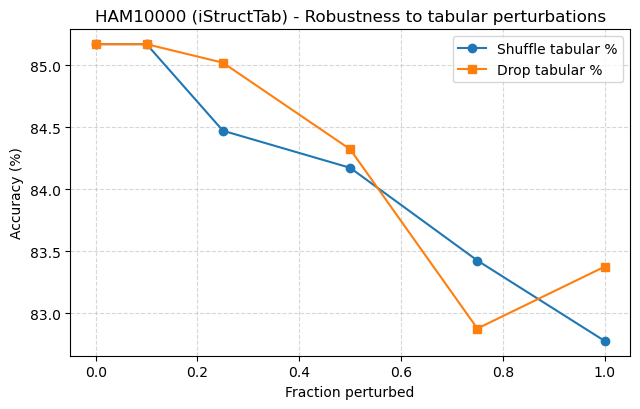

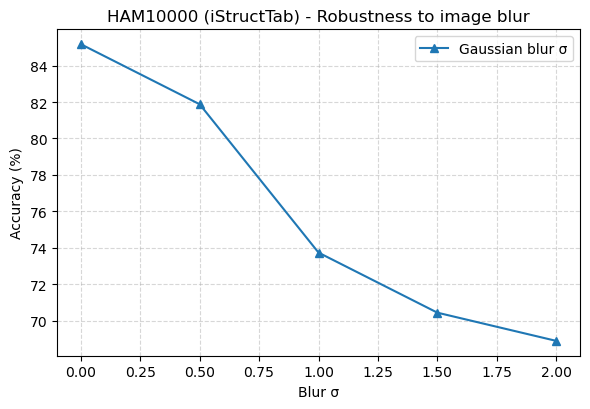

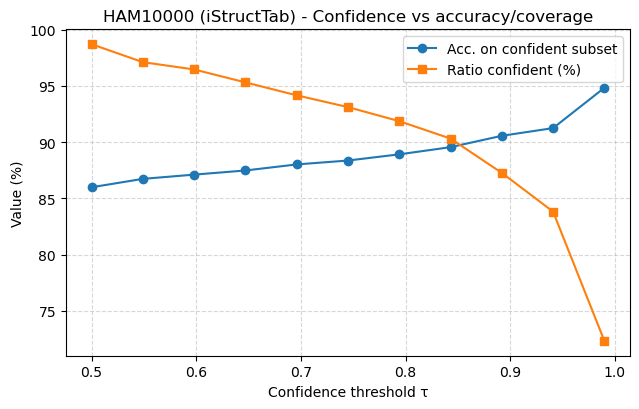

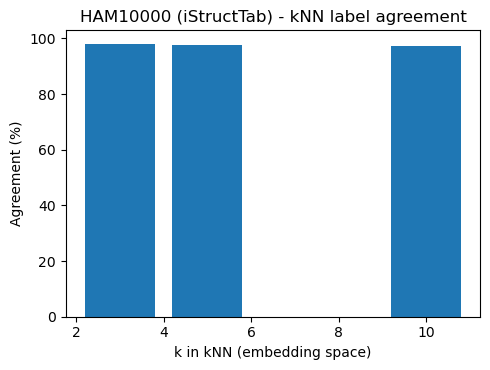

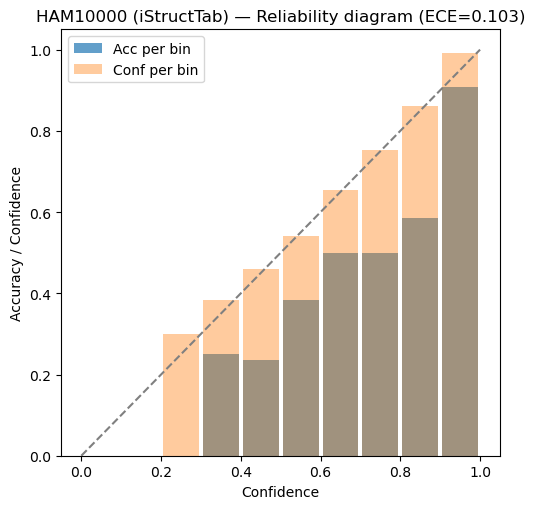

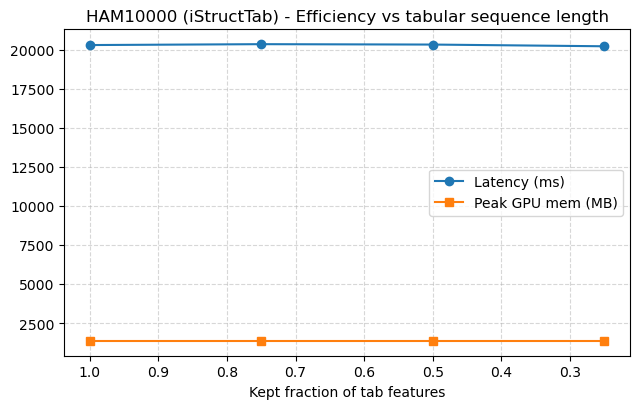

In [10]:
# ============================================================
# Ablation & Diagnostics for iStructTab on HAM10000 (Test Set)
# Requires: model_best, dl_test_best already defined from training cell
# ============================================================
import os, time, math, numpy as np, torch, matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.neighbors import NearestNeighbors
import torchvision.transforms.functional as TF
import pandas as pd

plt.rcParams.update({"savefig.facecolor":"white","figure.facecolor":"white"})

# ----- Hook iStructTab HAM model + test loader -----
model  = model_best.eval()      # from your iStructTab HAM training
loader = dl_test_best           # test DataLoader from that script
device = next(model.parameters()).device

print(f"[INFO] Using iStructTab HAM model on device={device}")
print(f"[INFO] Test batches: {len(loader)}")

# -------------------- Helpers --------------------
def _to_device(x_tab, x_img, y=None, dev=device):
    x_tab = {k: v.to(dev) for k, v in x_tab.items()}
    x_img = x_img.to(dev)
    if y is not None:
        y = y.to(dev)
    return x_tab, x_img, y

@torch.no_grad()
def predict_loader(loader, perturb=None):
    model.eval()
    logits_all, probs_all, preds_all, y_all, embs_all = [], [], [], [], []
    for x_tab, x_img, y in loader:
        if perturb is not None:
            x_tab, x_img = perturb(x_tab, x_img)
        x_tab, x_img, y = _to_device(x_tab, x_img, y)

        out = model(x_tab, x_img)
        logits = out["logits"]
        probs  = torch.softmax(logits, dim=1)
        preds  = probs.argmax(1)
        emb    = out.get("embeddings", logits)  # fallback if no explicit embeddings

        logits_all.append(logits.cpu())
        probs_all.append(probs.cpu())
        preds_all.append(preds.cpu())
        y_all.append(y.cpu())
        embs_all.append(emb.cpu())

    logits = torch.cat(logits_all)
    probs  = torch.cat(probs_all)
    preds  = torch.cat(preds_all)
    y      = torch.cat(y_all)
    embs   = torch.cat(embs_all).numpy()
    return logits.numpy(), probs.numpy(), preds.numpy(), y.numpy(), embs

# -------------------- Perturbations --------------------
def make_tab_shuffle_perturber(p):
    """Randomly permute a fraction p of numeric+categorical columns."""
    def _perturb(x_tab, x_img):
        x_tab = {k: v.clone() for k, v in x_tab.items()}
        n_num = x_tab["num"].shape[1] if x_tab["num"].ndim == 2 else 0
        n_cat = x_tab["cat"].shape[1] if x_tab["cat"].ndim == 2 else 0
        idx_all = np.arange(n_num + n_cat)
        k = int(round(p * len(idx_all)))
        if k > 0:
            cols = np.random.choice(idx_all, size=k, replace=False)
            B = x_tab["num"].shape[0]
            for c in cols:
                if c < n_num:
                    perm = torch.randperm(B)
                    x_tab["num"][:, c] = x_tab["num"][:, c][perm]
                else:
                    c2 = c - n_num
                    perm = torch.randperm(B)
                    x_tab["cat"][:, c2] = x_tab["cat"][:, c2][perm]
        return x_tab, x_img
    return _perturb

def make_tab_drop_perturber(p):
    """Replace a fraction p of columns with mean (num) or -1 (cat)."""
    def _perturb(x_tab, x_img):
        x_tab = {k: v.clone() for k, v in x_tab.items()}
        n_num = x_tab["num"].shape[1] if x_tab["num"].ndim == 2 else 0
        n_cat = x_tab["cat"].shape[1] if x_tab["cat"].ndim == 2 else 0
        idx_all = np.arange(n_num + n_cat)
        k = int(round(p * len(idx_all)))
        if k > 0:
            cols = np.random.choice(idx_all, size=k, replace=False)
            num_mean = x_tab["num"].mean(0) if n_num > 0 else None
            for c in cols:
                if c < n_num:
                    x_tab["num"][:, c] = num_mean[c]
                else:
                    c2 = c - n_num
                    x_tab["cat"][:, c2] = -1
        return x_tab, x_img
    return _perturb

def make_img_blur_perturber(sigma):
    """Apply Gaussian blur with std=sigma to all images."""
    def _perturb(x_tab, x_img):
        if sigma <= 0.0:
            return x_tab, x_img
        x_img = x_img.clone()
        k = max(3, int(2 * round(3 * sigma) + 1))
        for i in range(x_img.shape[0]):
            x_img[i] = TF.gaussian_blur(x_img[i], kernel_size=k, sigma=sigma)
        return x_tab, x_img
    return _perturb

# -------------------- 1. Robustness --------------------
ps     = [0.0, 0.1, 0.25, 0.5, 0.75, 1.0]
sigmas = [0.0, 0.5, 1.0, 1.5, 2.0]

def eval_accuracy(loader, perturb=None):
    _, _, preds, y, _ = predict_loader(loader, perturb)
    return accuracy_score(y, preds) * 100

acc_shuffle = [eval_accuracy(loader, make_tab_shuffle_perturber(p)) for p in ps]
acc_drop    = [eval_accuracy(loader, make_tab_drop_perturber(p)) for p in ps]
acc_blur    = [eval_accuracy(loader, make_img_blur_perturber(s)) for s in sigmas]

plt.figure(figsize=(6.5, 4.2))
plt.plot(ps, acc_shuffle, '-o', label='Shuffle tabular %')
plt.plot(ps, acc_drop,    '-s', label='Drop tabular %')
plt.xlabel("Fraction perturbed")
plt.ylabel("Accuracy (%)")
plt.title("HAM10000 (iStructTab) - Robustness to tabular perturbations")
plt.grid(True, ls='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.savefig("ham_istructtab_robustness_tabular.png", dpi=600, bbox_inches='tight')

plt.figure(figsize=(6.0, 4.2))
plt.plot(sigmas, acc_blur, '-^', label='Gaussian blur σ')
plt.xlabel("Blur σ")
plt.ylabel("Accuracy (%)")
plt.title("HAM10000 (iStructTab) - Robustness to image blur")
plt.grid(True, ls='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.savefig("ham_istructtab_robustness_image.png", dpi=600, bbox_inches='tight')

# -------------------- 2. Confidence & kNN consistency --------------------
taus = np.linspace(0.5, 0.99, 11)
_, probs, preds, y, embs = predict_loader(loader)
conf = probs.max(1)

idx_conf   = [np.where(conf >= t)[0] for t in taus]
acc_conf   = [accuracy_score(y[idx], preds[idx]) * 100 if len(idx) > 0 else np.nan for idx in idx_conf]
ratio_conf = [len(idx) / len(y) * 100 for idx in idx_conf]

nbrs = NearestNeighbors(n_neighbors=11, metric='euclidean').fit(embs)
neigh = nbrs.kneighbors(embs, return_distance=False)[:, 1:]

agree = []
for k in [3, 5, 10]:
    a = [(preds[neigh[i, :k]] == preds[i]).mean() for i in range(len(y))]
    agree.append(100 * np.mean(a))

plt.figure(figsize=(6.5, 4.2))
plt.plot(taus, acc_conf,   '-o', label='Acc. on confident subset')
plt.plot(taus, ratio_conf, '-s', label='Ratio confident (%)')
plt.xlabel("Confidence threshold τ")
plt.ylabel("Value (%)")
plt.title("HAM10000 (iStructTab) - Confidence vs accuracy/coverage")
plt.grid(True, ls='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.savefig("ham_istructtab_confidence_curve.png", dpi=600, bbox_inches='tight')

plt.figure(figsize=(5, 3.8))
plt.bar([3, 5, 10], agree, width=1.6)
plt.xlabel("k in kNN (embedding space)")
plt.ylabel("Agreement (%)")
plt.title("HAM10000 (iStructTab) - kNN label agreement")
plt.tight_layout()
plt.savefig("ham_istructtab_knn_agreement.png", dpi=600, bbox_inches='tight')

# -------------------- 3. Calibration --------------------
bins   = np.linspace(0.0, 1.0, 11)
bin_ids = np.digitize(conf, bins) - 1
acc_bin, conf_bin, cnt_bin = [], [], []

for b in range(len(bins) - 1):
    idx = np.where(bin_ids == b)[0]
    if len(idx) == 0:
        acc_bin.append(0.0)
        conf_bin.append(0.0)
        cnt_bin.append(0)
    else:
        acc_bin.append(accuracy_score(y[idx], preds[idx]))
        conf_bin.append(conf[idx].mean())
        cnt_bin.append(len(idx))

acc_bin  = np.array(acc_bin)
conf_bin = np.array(conf_bin)
ece = np.sum(np.abs(acc_bin - conf_bin) * (np.array(cnt_bin) / len(y)))

plt.figure(figsize=(5.2, 5.2))
plt.plot([0, 1], [0, 1], '--', color='gray')
plt.bar(bins[:-1] + 0.05, acc_bin,  width=0.09, alpha=0.7, label='Acc per bin')
plt.bar(bins[:-1] + 0.05, conf_bin, width=0.09, alpha=0.4, label='Conf per bin')
plt.xlabel("Confidence")
plt.ylabel("Accuracy / Confidence")
plt.title(f"HAM10000 (iStructTab) — Reliability diagram (ECE={ece:.3f})")
plt.legend()
plt.tight_layout()
plt.savefig("ham_istructtab_reliability.png", dpi=600, bbox_inches='tight')

# -------------------- 4. Efficiency vs tabular length --------------------
def eval_latency_mem(loader, keep_fracs=(1.0, 0.75, 0.5, 0.25)):
    # Inspect one batch to know original tab lengths
    first_batch = next(iter(loader))
    n_num = first_batch[0]["num"].shape[1]
    n_cat = first_batch[0]["cat"].shape[1]

    res = []
    for f in keep_fracs:
        kn = int(round(n_num * f))
        kc = int(round(n_cat * f))
        idx_num = np.arange(n_num)[:kn]
        idx_cat = np.arange(n_cat)[:kc]

        def pert(x_tab, x_img):
            x_tab = {k: v.clone() for k, v in x_tab.items()}
            x_tab["num"] = x_tab["num"][:, idx_num]
            x_tab["cat"] = x_tab["cat"][:, idx_cat]
            return x_tab, x_img

        if device.type == 'cuda':
            torch.cuda.reset_peak_memory_stats(device)
        t0 = time.time()
        predict_loader(loader, pert)
        t1 = time.time()
        peak = torch.cuda.max_memory_allocated(device) / 1e6 if device.type == 'cuda' else 0
        res.append((f, (t1 - t0), peak))
    return res

eff        = eval_latency_mem(loader)
fracs, lat, mem = zip(*eff)

plt.figure(figsize=(6.5, 4.2))
plt.plot(fracs, np.array(lat) * 1000, '-o', label='Latency (ms)')
if device.type == 'cuda':
    plt.plot(fracs, mem, '-s', label='Peak GPU mem (MB)')
plt.gca().invert_xaxis()
plt.xlabel("Kept fraction of tab features")
plt.title("HAM10000 (iStructTab) - Efficiency vs tabular sequence length")
plt.grid(True, ls='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.savefig("ham_istructtab_efficiency.png", dpi=600, bbox_inches='tight')

# -------------------- Summary table --------------------
df_summary = pd.DataFrame({
    "Tab Shuffle ↓": acc_shuffle,
    "Tab Drop ↓":    acc_drop,
    "Img Blur σ":    sigmas + [np.nan] * (len(ps) - len(sigmas))
}, index=[f"{p:.2f}" for p in ps])
df_summary["kNN-Agree@5"] = agree[1]

print("\n=== HAM10000 + iStructTab Ablation Summary ===")
print(df_summary.round(2))
print(f"\nExpected Calibration Error (ECE): {ece:.3f}")

# Sanity & Stress Diagnostics

[INFO] Extra tests using iStructTab on device=cuda:2
Mode=full         | Acc =  85.17 % (n=2003)
Mode=image_only   | Acc =  83.37 % (n=2003)
Mode=tab_only     | Acc =  66.40 % (n=2003)
Mode=shuffle_tab  | Acc =  82.38 % (n=2003)
Mode=shuffle_img  | Acc =  53.92 % (n=2003)

=== Augmentation consistency / stress (iStructTab) ===
Base accuracy:  85.17 %
TTA majority-vote accuracy (n_aug=5):  68.95 %
Fraction of samples with any label change across aug:  42.04 %

=== Per-class accuracy summary (iStructTab, top 10 by support) ===
   class_id  support  accuracy
5         5     1330     95.79
2         2      237     64.98
4         4      229     61.57
1         1       89     82.02
0         0       65     46.15
3         3       27     48.15
6         6       26     80.77

=== Bucketed per-class accuracy (iStructTab, by support) ===
        count   mean
bucket              
head        2  80.38
medium      3  63.25
tail        2  64.46

[Done] Extra sanity & stress tests (iStructTab) compl

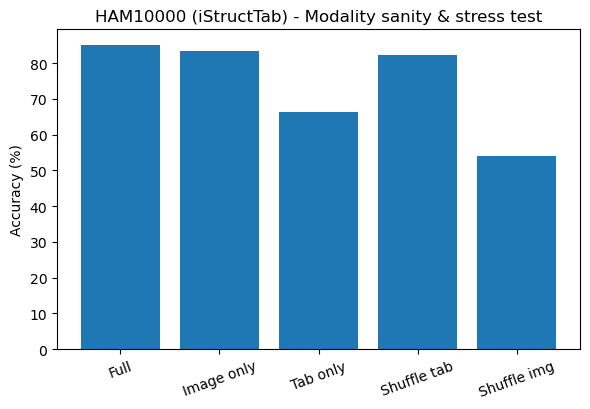

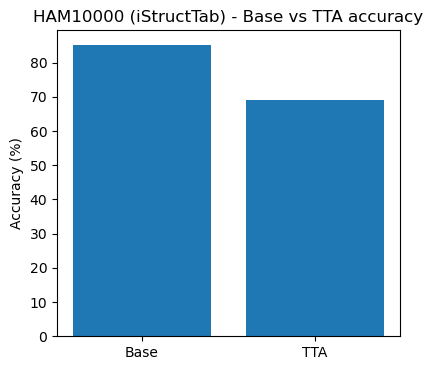

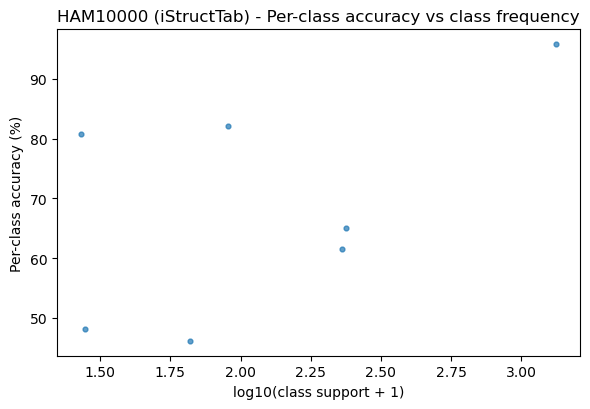

In [11]:
# ===================== Extra sanity & stress tests (HAM10000 + iStructTab) =====================
import numpy as np
import torch
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter
from sklearn.metrics import accuracy_score
import torchvision.transforms.functional as TF

plt.rcParams.update({"savefig.facecolor": "white", "figure.facecolor": "white"})

# Hook in iStructTab model + test loader
model  = model_best.eval()      # from iStructTab HAM training
loader = dl_test_best           # test loader from that script
device = next(model.parameters()).device
print(f"[INFO] Extra tests using iStructTab on device={device}")

# Sanity check: verify predict_loader exists (from ablation pack)
try:
    _ = predict_loader
except NameError as e:
    raise RuntimeError(
        "predict_loader is not defined. Run the iStructTab ablation pack cell first."
    ) from e

# -------------------------------------------------------------------
# 1. Modality sanity & stress tests
#    - Full (image + tabular)
#    - Image-only (tabular wiped)
#    - Tab-only (image wiped / averaged)
#    - Mismatched modalities (shuffle tab or images)
# -------------------------------------------------------------------
def _clone_batch(x_tab, x_img):
    x_tab = {k: v.clone() for k, v in x_tab.items()}
    x_img = x_img.clone()
    return x_tab, x_img

def make_modality_perturber(mode):
    """
    mode ∈ {"full", "image_only", "tab_only", "shuffle_tab", "shuffle_img"}.
    """
    assert mode in {"full", "image_only", "tab_only", "shuffle_tab", "shuffle_img"}

    def _perturb(x_tab, x_img):
        x_tab, x_img = _clone_batch(x_tab, x_img)
        B = x_img.shape[0]

        if mode == "full":
            return x_tab, x_img

        # Useful stats
        if "num" in x_tab and x_tab["num"] is not None and x_tab["num"].ndim == 2:
            num_mean = x_tab["num"].mean(dim=0, keepdim=True)
        else:
            num_mean = None

        if mode == "image_only":
            # Keep images, wipe tabular signal
            if num_mean is not None:
                x_tab["num"][:] = num_mean
            if "cat" in x_tab and x_tab["cat"] is not None:
                x_tab["cat"][:] = -1   # unseen category id
            return x_tab, x_img

        if mode == "tab_only":
            # Keep tabular, replace images with blurred batch-average
            mean_img = x_img.mean(dim=0, keepdim=True)
            k = 9
            sig = 2.0
            mean_img_blur = TF.gaussian_blur(mean_img, kernel_size=k, sigma=sig)
            x_img[:] = mean_img_blur
            return x_tab, x_img

        if mode == "shuffle_tab":
            # Shuffle tab rows within batch (break alignment with images)
            perm = torch.randperm(B)
            if "num" in x_tab and x_tab["num"] is not None:
                x_tab["num"] = x_tab["num"][perm]
            if "cat" in x_tab and x_tab["cat"] is not None:
                x_tab["cat"] = x_tab["cat"][perm]
            return x_tab, x_img

        if mode == "shuffle_img":
            # Shuffle images within batch (break alignment with tabular)
            perm = torch.randperm(B)
            x_img = x_img[perm]
            return x_tab, x_img

        return x_tab, x_img

    return _perturb

@torch.no_grad()
def eval_modality_modes(loader, modes):
    results = {}
    for m in modes:
        _, _, preds, y, _ = predict_loader(loader, perturb=make_modality_perturber(m))
        acc = accuracy_score(y, preds) * 100
        results[m] = acc
        print(f"Mode={m:12s} | Acc = {acc:6.2f} % (n={len(y)})")
    return results

modes = ["full", "image_only", "tab_only", "shuffle_tab", "shuffle_img"]
modality_results = eval_modality_modes(loader, modes)

# Plot as bar chart (iStructTab)
plt.figure(figsize=(6.0, 4.2))
names = ["Full", "Image only", "Tab only", "Shuffle tab", "Shuffle img"]
vals = [modality_results[m] for m in modes]
plt.bar(range(len(names)), vals)
plt.xticks(range(len(names)), names, rotation=20)
plt.ylabel("Accuracy (%)")
plt.title("HAM10000 (iStructTab) - Modality sanity & stress test")
plt.tight_layout()
plt.savefig("ham_istructtab_modality_sanity_stress.png", dpi=600, bbox_inches="tight")

# -------------------------------------------------------------------
# 2. Augmentation consistency / stress test
# -------------------------------------------------------------------
def random_augment_batch(x_img):
    x_img = x_img.clone()
    B = x_img.shape[0]
    for i in range(B):
        img = x_img[i]

        # Random horizontal flip
        if torch.rand(1).item() < 0.5:
            img = TF.hflip(img)

        # Small random rotation
        angle = np.random.uniform(-15, 15)
        img = TF.rotate(img, angle, interpolation=TF.InterpolationMode.BILINEAR)

        # Simple brightness/contrast jitter
        b = np.random.uniform(0.9, 1.1)
        c = np.random.uniform(0.9, 1.1)
        mean = img.mean(dim=(1, 2), keepdim=True)
        img = (img - mean) * c + mean
        img = img * b

        # Tiny Gaussian noise
        noise = torch.randn_like(img) * 0.01
        img = img + noise

        # Note: data are ImageNet-normalized; this clamp keeps values reasonable
        img = img.clamp(min=0.0, max=1.0)
        x_img[i] = img
    return x_img

@torch.no_grad()
def predict_with_aug(loader, n_aug=5):
    # Base predictions
    _, probs_base, preds_base, y, _ = predict_loader(loader, perturb=None)
    preds_base = preds_base
    y = y

    # Augmented predictions
    all_aug_preds = []
    for j in range(n_aug):
        preds_all = []
        for x_tab, x_img, y_batch in loader:
            x_tab, x_img, _ = _to_device(x_tab, x_img, None, dev=device)
            x_img_aug = random_augment_batch(x_img)
            out = model(x_tab, x_img_aug)
            probs = torch.softmax(out["logits"], dim=1)
            preds = probs.argmax(1)
            preds_all.append(preds.cpu())
        preds_all = torch.cat(preds_all).numpy()
        all_aug_preds.append(preds_all)

    all_aug_preds = np.stack(all_aug_preds, axis=1)  # [N, n_aug]

    # Majority Vote
    maj_preds = []
    for i in range(all_aug_preds.shape[0]):
        vals, counts = np.unique(all_aug_preds[i], return_counts=True)
        maj_preds.append(vals[counts.argmax()])
    maj_preds = np.array(maj_preds)

    # Metrics
    base_acc = accuracy_score(y, preds_base) * 100
    tta_acc = accuracy_score(y, maj_preds) * 100
    change_mask = (all_aug_preds != preds_base[:, None]).any(axis=1)
    frac_changed = change_mask.mean() * 100

    print("\n=== Augmentation consistency / stress (iStructTab) ===")
    print(f"Base accuracy: {base_acc:6.2f} %")
    print(f"TTA majority-vote accuracy (n_aug={n_aug}): {tta_acc:6.2f} %")
    print(f"Fraction of samples with any label change across aug: {frac_changed:6.2f} %")

    return {
        "base_acc": base_acc,
        "tta_acc": tta_acc,
        "frac_changed": frac_changed,
        "y": y,
        "preds_base": preds_base,
        "maj_preds": maj_preds,
        "all_aug_preds": all_aug_preds,
    }

aug_results = predict_with_aug(loader, n_aug=5)

# Base vs TTA accuracy
plt.figure(figsize=(4.2, 3.8))
plt.bar([0, 1], [aug_results["base_acc"], aug_results["tta_acc"]])
plt.xticks([0, 1], ["Base", "TTA"])
plt.ylabel("Accuracy (%)")
plt.title("HAM10000 (iStructTab) - Base vs TTA accuracy")
plt.tight_layout()
plt.savefig("ham_istructtab_tta_accuracy.png", dpi=600, bbox_inches="tight")

# -------------------------------------------------------------------
# 3. Per-class accuracy vs class frequency
# -------------------------------------------------------------------
_, _, preds_full, y_full, _ = predict_loader(loader, perturb=None)
labels = y_full
preds  = preds_full

classes = np.unique(labels)
per_class_acc = []
per_class_cnt = []
for c in classes:
    idx = np.where(labels == c)[0]
    per_class_cnt.append(len(idx))
    if len(idx) > 0:
        per_class_acc.append(accuracy_score(labels[idx], preds[idx]) * 100)
    else:
        per_class_acc.append(np.nan)

per_class_acc = np.array(per_class_acc)
per_class_cnt = np.array(per_class_cnt)

df_pc = pd.DataFrame({
    "class_id": classes,
    "support": per_class_cnt,
    "accuracy": per_class_acc,
})
df_pc = df_pc.sort_values("support", ascending=False)

print("\n=== Per-class accuracy summary (iStructTab, top 10 by support) ===")
print(df_pc.head(10).round(2))

# Bucket head/medium/tail by support quantiles
quantiles = df_pc["support"].quantile([0.33, 0.67]).values
q1, q2 = quantiles[0], quantiles[1]

def _bucket(s):
    if s >= q2: return "head"
    if s >= q1: return "medium"
    return "tail"

df_pc["bucket"] = df_pc["support"].apply(_bucket)
bucket_summary = df_pc.groupby("bucket")["accuracy"].agg(["count", "mean"])
print("\n=== Bucketed per-class accuracy (iStructTab, by support) ===")
print(bucket_summary.round(2))

# Scatter: log10 support vs accuracy
plt.figure(figsize=(6.0, 4.2))
x = np.log10(df_pc["support"] + 1)
y_sc = df_pc["accuracy"]
plt.scatter(x, y_sc, s=12, alpha=0.7)
plt.xlabel("log10(class support + 1)")
plt.ylabel("Per-class accuracy (%)")
plt.title("HAM10000 (iStructTab) - Per-class accuracy vs class frequency")
plt.tight_layout()
plt.savefig("ham_istructtab_per_class_accuracy.png", dpi=600, bbox_inches="tight")

print("\n[Done] Extra sanity & stress tests (iStructTab) complete.")
print("Saved figures:")
print("  - ham_istructtab_modality_sanity_stress.png")
print("  - ham_istructtab_tta_accuracy.png")
print("  - ham_istructtab_per_class_accuracy.png")

# Additional Reliability and Interpretability Diagnostics

[INFO] Diagnostics using iStructTab on device=cuda:2
Base accuracy on loader: 85.17% (N=2003)

=== Top-10 most frequent confusions (true → predicted) ===
 1. true=4 → pred=5 | count=73
 2. true=2 → pred=4 | count=46
 3. true=5 → pred=4 | count=29
 4. true=2 → pred=5 | count=27
 5. true=4 → pred=2 | count=11
 6. true=5 → pred=2 | count=10
 7. true=0 → pred=1 | count=10
 8. true=0 → pred=4 | count=9
 9. true=5 → pred=3 | count=8
10. true=0 → pred=3 | count=8
Top-1 accuracy: 85.17%
Top-2 accuracy: 94.01%
Top-3 accuracy: 97.05%
Top-5 accuracy: 99.20%

Mean margin (correct): 0.954
Mean margin (wrong)  : 0.717

Detected features: 1 numeric, 4 categorical

=== Per-feature permutation importance (accuracy drop, % points) ===
Baseline accuracy: 85.17%
num:age              | acc= 84.52% | drop=  0.65 pts
cat:lesion_id        | acc= 85.22% | drop= -0.05 pts
cat:dx_type          | acc= 83.57% | drop=  1.60 pts
cat:sex              | acc= 85.17% | drop=  0.00 pts
cat:localization     | acc= 85.17% 

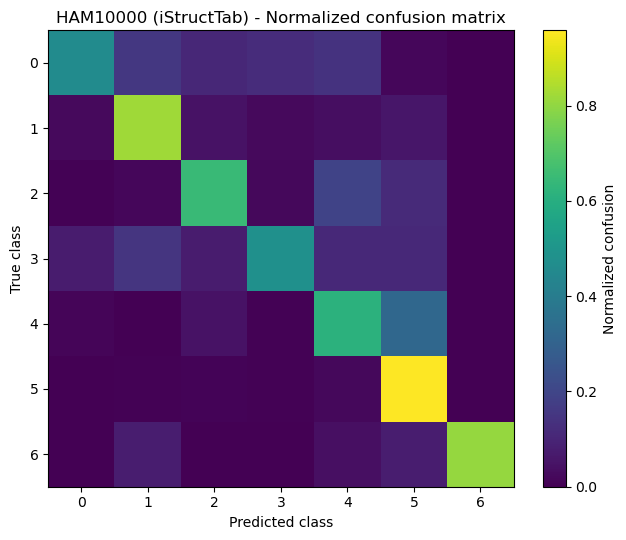

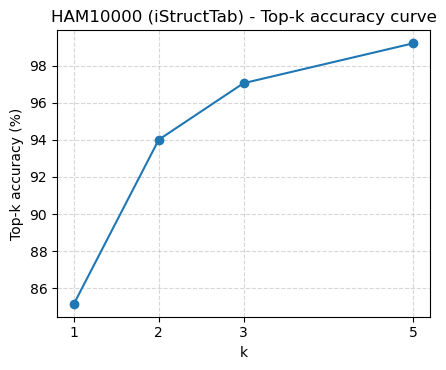

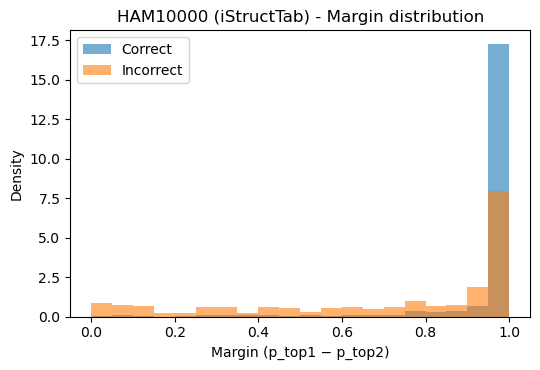

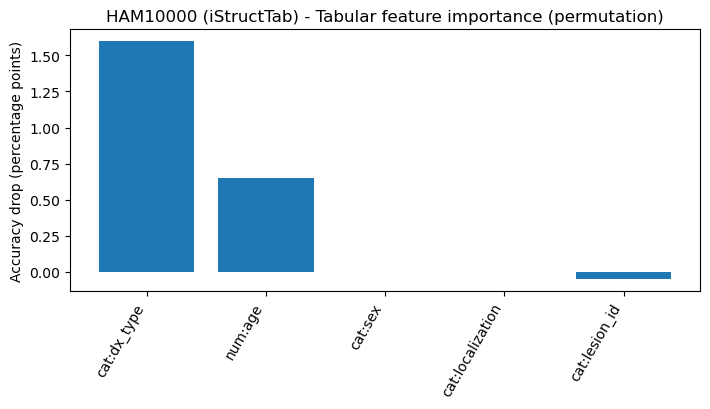

In [12]:
# ===================== Extra diagnostics pack (HAM10000 + iStructTab) =====================
import numpy as np
import torch
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import confusion_matrix, accuracy_score, top_k_accuracy_score

plt.rcParams.update({"savefig.facecolor": "white", "figure.facecolor": "white"})

# Use iStructTab model + HAM test loader
model  = model_best.eval()      # from iStructTab HAM script
loader = dl_test_best           # HAM test DataLoader
device = next(model.parameters()).device
print(f"[INFO] Diagnostics using iStructTab on device={device}")

# Sanity: one forward pass via predict_loader (from ablation pack)
logits, probs, preds, y, embs = predict_loader(loader, perturb=None)
num_classes = len(np.unique(y))
base_acc = accuracy_score(y, preds) * 100
print(f"Base accuracy on loader: {base_acc:.2f}% (N={len(y)})")

# -------------------------------------------------------------------
# 1. Confusion matrix + normalized confusion
# -------------------------------------------------------------------
cm = confusion_matrix(y, preds, labels=np.arange(num_classes))
with np.errstate(divide="ignore", invalid="ignore"):
    cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)
    cm_norm[np.isnan(cm_norm)] = 0.0

plt.figure(figsize=(6.5, 5.5))
plt.imshow(cm_norm, interpolation="nearest", aspect="auto")
plt.colorbar(label="Normalized confusion")
plt.xlabel("Predicted class")
plt.ylabel("True class")
plt.title("HAM10000 (iStructTab) - Normalized confusion matrix")
plt.tight_layout()
plt.savefig("ham_istructtab_confusion_matrix_norm.png", dpi=600, bbox_inches="tight")

# Print top-10 most confused pairs (excluding diagonal)
conf_pairs = []
for i in range(num_classes):
    for j in range(num_classes):
        if i == j:
            continue
        if cm[i, j] > 0:
            conf_pairs.append((cm[i, j], i, j))
conf_pairs.sort(reverse=True)
print("\n=== Top-10 most frequent confusions (true → predicted) ===")
for k in range(min(10, len(conf_pairs))):
    c, i, j = conf_pairs[k]
    print(f"{k+1:2d}. true={i} → pred={j} | count={c}")

# -------------------------------------------------------------------
# 2. Top-k accuracy curve (k = 1..5)
# -------------------------------------------------------------------
ks = [1, 2, 3, 5]
topk_accs = []
for k in ks:
    acc_k = top_k_accuracy_score(y, probs, k=k) * 100
    topk_accs.append(acc_k)
    print(f"Top-{k} accuracy: {acc_k:.2f}%")

plt.figure(figsize=(4.5, 3.8))
plt.plot(ks, topk_accs, "-o")
plt.xticks(ks)
plt.xlabel("k")
plt.ylabel("Top-k accuracy (%)")
plt.title("HAM10000 (iStructTab) - Top-k accuracy curve")
plt.grid(True, ls="--", alpha=0.5)
plt.tight_layout()
plt.savefig("ham_istructtab_topk_accuracy.png", dpi=600, bbox_inches="tight")

# -------------------------------------------------------------------
# 3. Margin / confidence separation
#    margin = p_top1 - p_top2, compare distribution for correct vs wrong
# -------------------------------------------------------------------
sorted_probs = np.sort(probs, axis=1)[:, ::-1]
top1 = sorted_probs[:, 0]
top2 = sorted_probs[:, 1] if sorted_probs.shape[1] > 1 else np.zeros_like(top1)
margins = top1 - top2

correct = (preds == y)
margins_correct = margins[correct]
margins_wrong   = margins[~correct]

print(f"\nMean margin (correct): {margins_correct.mean():.3f}")
print(f"Mean margin (wrong)  : {margins_wrong.mean():.3f}")

plt.figure(figsize=(5.5, 3.8))
bins = np.linspace(0.0, 1.0, 21)
plt.hist(margins_correct, bins=bins, alpha=0.6, label="Correct", density=True)
plt.hist(margins_wrong,   bins=bins, alpha=0.6, label="Incorrect", density=True)
plt.xlabel("Margin (p_top1 − p_top2)")
plt.ylabel("Density")
plt.title("HAM10000 (iStructTab) - Margin distribution")
plt.legend()
plt.tight_layout()
plt.savefig("ham_istructtab_margin_hist.png", dpi=600, bbox_inches="tight")

# -------------------------------------------------------------------
# 4. Per-feature tabular importance via permutation
#    (accuracy drop when shuffling one feature at a time)
# -------------------------------------------------------------------
# Get n_num, n_cat from one batch
batch = next(iter(loader))
x_tab0, x_img0, _ = batch
n_num = x_tab0["num"].shape[1] if ("num" in x_tab0 and x_tab0["num"].ndim == 2) else 0
n_cat = x_tab0["cat"].shape[1] if ("cat" in x_tab0 and x_tab0["cat"].ndim == 2) else 0
print(f"\nDetected features: {n_num} numeric, {n_cat} categorical")

def make_single_feature_shuffler(idx, kind):
    """
    kind ∈ {"num", "cat"}; idx is column index in that group.
    """
    assert kind in {"num", "cat"}
    def _perturb(x_tab, x_img):
        x_tab = {k: v.clone() for k, v in x_tab.items()}
        B = x_img.shape[0]
        perm = torch.randperm(B)
        if kind == "num" and "num" in x_tab and x_tab["num"].ndim == 2:
            x_tab["num"][:, idx] = x_tab["num"][perm, idx]
        if kind == "cat" and "cat" in x_tab and x_tab["cat"].ndim == 2:
            x_tab["cat"][:, idx] = x_tab["cat"][perm, idx]
        return x_tab, x_img
    return _perturb

def eval_accuracy(loader, perturb=None):
    _, _, p, yy, _ = predict_loader(loader, perturb=perturb)
    return accuracy_score(yy, p) * 100

# Try to use real column names if ds is available
num_names = None
cat_names = None
if "ds" in globals():
    try:
        num_names = getattr(ds, "num_cols", None)
        cat_names = getattr(ds, "cat_cols", None)
    except Exception:
        num_names, cat_names = None, None

feat_labels = []
drops = []

print("\n=== Per-feature permutation importance (accuracy drop, % points) ===")
print(f"Baseline accuracy: {base_acc:.2f}%")

# Numeric features
for i in range(n_num):
    acc_i = eval_accuracy(loader, perturb=make_single_feature_shuffler(i, "num"))
    drop = base_acc - acc_i
    if num_names is not None and i < len(num_names):
        fname = f"num:{num_names[i]}"
    else:
        fname = f"num_{i}"
    drops.append(("num", i, drop, fname))
    print(f"{fname:20s} | acc={acc_i:6.2f}% | drop={drop:6.2f} pts")

# Categorical features
for j in range(n_cat):
    acc_j = eval_accuracy(loader, perturb=make_single_feature_shuffler(j, "cat"))
    drop = base_acc - acc_j
    if cat_names is not None and j < len(cat_names):
        fname = f"cat:{cat_names[j]}"
    else:
        fname = f"cat_{j}"
    drops.append(("cat", j, drop, fname))
    print(f"{fname:20s} | acc={acc_j:6.2f}% | drop={drop:6.2f} pts")

df_imp = pd.DataFrame(drops, columns=["kind", "idx", "acc_drop", "feat"])
df_imp = df_imp.sort_values("acc_drop", ascending=False)

print("\nTop-15 most important tabular features (by accuracy drop):")
print(df_imp.head(15).round(2))

# Bar plot for the top-K features
K = min(20, len(df_imp))
top_df = df_imp.head(K)
plt.figure(figsize=(7.2, 4.2))
plt.bar(range(K), top_df["acc_drop"])
plt.xticks(range(K), top_df["feat"], rotation=60, ha="right")
plt.ylabel("Accuracy drop (percentage points)")
plt.title("HAM10000 (iStructTab) - Tabular feature importance (permutation)")
plt.tight_layout()
plt.savefig("ham_istructtab_tab_feature_importance.png", dpi=600, bbox_inches="tight")

print("\n[Done] Extra diagnostics pack (iStructTab) finished.")
print("Saved figures:")
print("  - ham_istructtab_confusion_matrix_norm.png")
print("  - ham_istructtab_topk_accuracy.png")
print("  - ham_istructtab_margin_hist.png")
print("  - ham_istructtab_tab_feature_importance.png")

# Theory-Inspired Representation Diagnostics

[INFO] Theory-ish diagnostics using iStructTab on device=cuda:2
[Info] N=2003 samples, embedding dim=7
[Info] Base top-1 accuracy: 85.17%

[Geom] Effective dimension (participation ratio): 2.3

[Geom] Components needed for target variance:
   target_var  k_components
0        0.50             1
1        0.80             3
2        0.90             3
3        0.95             4
4        0.99             6
[kNN] Leave-one-out kNN accuracy (k=1): 79.13%
[kNN] Leave-one-out kNN accuracy (k=3): 82.68%
[kNN] Leave-one-out kNN accuracy (k=5): 83.97%
[kNN] Leave-one-out kNN accuracy (k=10): 84.77%
[kNN] Leave-one-out kNN accuracy (k=20): 85.67%

[Margin] Mean normalized margin (correct):  0.7406
[Margin] Mean normalized margin (incorrect): -0.5043

[Done] Theory-ish diagnostics (iStructTab) complete.
Saved figures:
  - ham_istructtab_embedding_spectrum.png
  - ham_istructtab_embedding_cumulative_variance.png
  - ham_istructtab_knn_vs_head.png
  - ham_istructtab_margin_conditional_error.png
  -

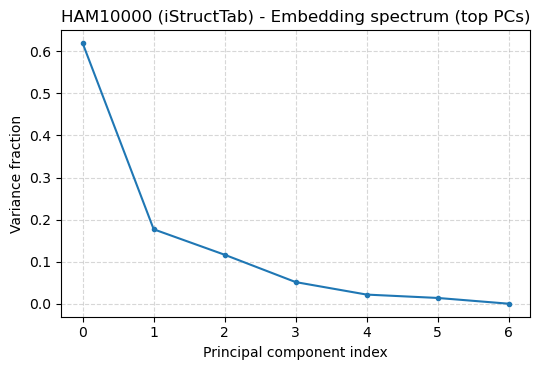

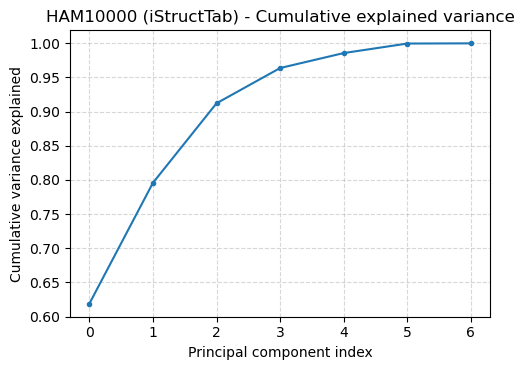

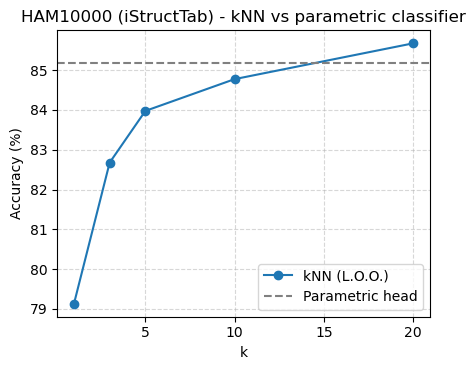

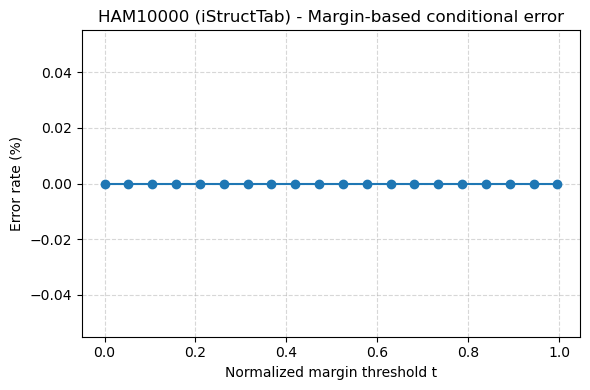

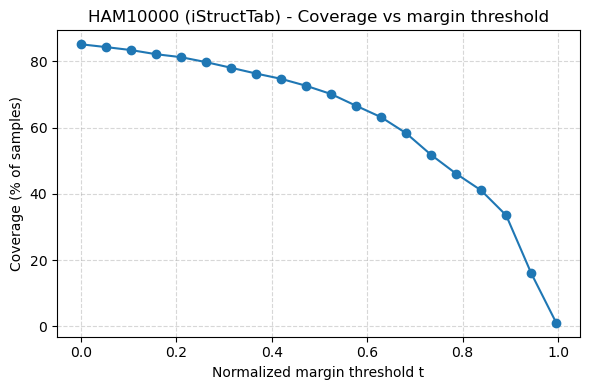

In [13]:
# ============= Theory-ish diagnostics: geometry, kNN, margins (iStructTab + HAM10000) =============
import numpy as np
import torch
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

plt.rcParams.update({"savefig.facecolor": "white", "figure.facecolor": "white"})

# Use iStructTab best model + HAM test loader
model  = model_best.eval()      # iStructTab HAM model
loader = dl_test_best           # HAM test DataLoader
device = next(model.parameters()).device
print(f"[INFO] Theory-ish diagnostics using iStructTab on device={device}")

# ---------- 0. Get cached predictions & embeddings ----------
logits, probs, preds, y, embs = predict_loader(loader, perturb=None)
y     = np.asarray(y)
preds = np.asarray(preds)
N, D  = embs.shape
print(f"[Info] N={N} samples, embedding dim={D}")
base_acc = accuracy_score(y, preds) * 100
print(f"[Info] Base top-1 accuracy: {base_acc:.2f}%")

# ---------- 1. Representation spectrum & effective dimension ----------
# Center embeddings
embs_c = embs - embs.mean(axis=0, keepdims=True)
# Covariance in embedding space (D x D)
cov = np.cov(embs_c, rowvar=False)  # shape (D, D)

# Eigenvalues of covariance (variance along PCs)
evals, _ = np.linalg.eigh(cov)
evals = np.sort(np.maximum(evals, 0))[::-1]  # descending, clamp negatives

total_var = evals.sum() + 1e-12
explained = evals / total_var
cum_expl  = np.cumsum(explained)

# Effective dimension (participation ratio)
eff_dim = (total_var**2) / (np.sum(evals**2) + 1e-12)
print(f"\n[Geom] Effective dimension (participation ratio): {eff_dim:.1f}")

plt.figure(figsize=(5.5, 3.8))
plt.plot(explained[: min(100, D)], "-o", markersize=3)
plt.xlabel("Principal component index")
plt.ylabel("Variance fraction")
plt.title("HAM10000 (iStructTab) - Embedding spectrum (top PCs)")
plt.grid(True, ls="--", alpha=0.5)
plt.tight_layout()
plt.savefig("ham_istructtab_embedding_spectrum.png", dpi=600, bbox_inches="tight")

plt.figure(figsize=(5.1, 3.8))
plt.plot(cum_expl[: min(100, D)], "-o", markersize=3)
plt.xlabel("Principal component index")
plt.ylabel("Cumulative variance explained")
plt.title("HAM10000 (iStructTab) - Cumulative explained variance")
plt.grid(True, ls="--", alpha=0.5)
plt.tight_layout()
plt.savefig("ham_istructtab_embedding_cumulative_variance.png", dpi=600, bbox_inches="tight")

# Small table: how many components to get X% variance
targets = [0.5, 0.8, 0.9, 0.95, 0.99]
rows = []
for t in targets:
    k = int(np.searchsorted(cum_expl, t) + 1)
    rows.append({"target_var": t, "k_components": k})
df_var = pd.DataFrame(rows)
print("\n[Geom] Components needed for target variance:")
print(df_var)

# ---------- 2. kNN classifier vs parametric head ----------
# Use embeddings as features; perform leave-one-out style kNN on the SAME set
ks = [1, 3, 5, 10, 20]
knn_accs = []

nbrs = KNeighborsClassifier(n_neighbors=max(ks) + 1, metric="euclidean")
nbrs.fit(embs, y)
dist, neigh_idx = nbrs.kneighbors(embs, return_distance=True)  # shape (N, maxk+1)

for k in ks:
    # For each sample, drop self index (should be first neighbor)
    neigh_k = neigh_idx[:, 1 : k + 1]
    y_pred_knn = []
    for i in range(N):
        neigh_labels = y[neigh_k[i]]
        vals, counts = np.unique(neigh_labels, return_counts=True)
        y_pred_knn.append(vals[counts.argmax()])
    y_pred_knn = np.array(y_pred_knn)
    acc_k = accuracy_score(y, y_pred_knn) * 100
    knn_accs.append(acc_k)
    print(f"[kNN] Leave-one-out kNN accuracy (k={k}): {acc_k:.2f}%")

plt.figure(figsize=(4.5, 3.8))
plt.plot(ks, knn_accs, "-o", label="kNN (L.O.O.)")
plt.axhline(base_acc, color="gray", linestyle="--", label="Parametric head")
plt.xlabel("k")
plt.ylabel("Accuracy (%)")
plt.title("HAM10000 (iStructTab) - kNN vs parametric classifier")
plt.grid(True, ls="--", alpha=0.5)
plt.legend()
plt.tight_layout()
plt.savefig("ham_istructtab_knn_vs_head.png", dpi=600, bbox_inches="tight")

# ---------- 3. Margin-based view (TCS-ish) ----------
# Margin: f_y(x) - max_{j≠y} f_j(x), using logits
logits_np   = np.asarray(logits)
true_logits = logits_np[np.arange(N), y]

# set true class logit to a very low value temporarily to get second-best
tmp = logits_np.copy()
tmp[np.arange(N), y] = -1e9
second_best = tmp.max(axis=1)
margins = true_logits - second_best  # raw logit margin

# Normalize by L2 norm of logit vector (scale invariance)
logit_norm   = np.linalg.norm(logits_np, axis=1) + 1e-12
norm_margins = margins / logit_norm

correct = (preds == y)
m_corr  = norm_margins[correct]
m_wrong = norm_margins[~correct]

print(f"\n[Margin] Mean normalized margin (correct):  {m_corr.mean():.4f}")
print(f"[Margin] Mean normalized margin (incorrect): {m_wrong.mean():.4f}")

# Margin-thresholded error rate (TCS-style margin curve)
ths = np.linspace(0.0, np.percentile(norm_margins, 99), 20)
err_cond = []
cov_cond = []
for t in ths:
    idx = np.where(norm_margins >= t)[0]
    if len(idx) == 0:
        err_cond.append(np.nan)
        cov_cond.append(0.0)
    else:
        err_cond.append(1.0 - accuracy_score(y[idx], preds[idx]))
        cov_cond.append(len(idx) / N)

err_cond = np.array(err_cond) * 100  # %
cov_cond = np.array(cov_cond) * 100  # %

plt.figure(figsize=(6.0, 4.0))
plt.plot(ths, err_cond, "-o", label="Error rate on {margin ≥ t}")
plt.xlabel("Normalized margin threshold t")
plt.ylabel("Error rate (%)")
plt.title("HAM10000 (iStructTab) - Margin-based conditional error")
plt.grid(True, ls="--", alpha=0.5)
plt.tight_layout()
plt.savefig("ham_istructtab_margin_conditional_error.png", dpi=600, bbox_inches="tight")

plt.figure(figsize=(6.0, 4.0))
plt.plot(ths, cov_cond, "-o", label="Coverage")
plt.xlabel("Normalized margin threshold t")
plt.ylabel("Coverage (% of samples)")
plt.title("HAM10000 (iStructTab) - Coverage vs margin threshold")
plt.grid(True, ls="--", alpha=0.5)
plt.tight_layout()
plt.savefig("ham_istructtab_margin_coverage.png", dpi=600, bbox_inches="tight")

print("\n[Done] Theory-ish diagnostics (iStructTab) complete.")
print("Saved figures:")
print("  - ham_istructtab_embedding_spectrum.png")
print("  - ham_istructtab_embedding_cumulative_variance.png")
print("  - ham_istructtab_knn_vs_head.png")
print("  - ham_istructtab_margin_conditional_error.png")
print("  - ham_istructtab_margin_coverage.png")

# Turing-Style Human-Model Evaluation

In [14]:
# ============================ Turing-test kit for HAM10000 (iStructTab) ============================
import os, math, random
from pathlib import Path

import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image
from sklearn.metrics import accuracy_score, confusion_matrix

plt.rcParams.update({"savefig.facecolor": "white", "figure.facecolor": "white"})

# ------------ Use iStructTab model + HAM test loader ------------
model  = model_best.eval()      # iStructTab HAM model
loader = dl_test_best           # HAM test DataLoader (must be shuffle=False)
device = next(model.parameters()).device
print(f"[INFO] Turing-test kit using iStructTab on device={device}")

# ------------ Config ------------
SAMPLE_N   = 60                    # how many images you want in the Turing test
OUT_DIR    = Path("ham_istructtab_turing_test")
IMG_DIR    = OUT_DIR / "images"
CSV_PATH   = OUT_DIR / "ham_istructtab_turing_sheet.csv"

# If your images are normalized with ImageNet stats, use these:
IMAGENET_MEAN = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
IMAGENET_STD  = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)

OUT_DIR.mkdir(parents=True, exist_ok=True)
IMG_DIR.mkdir(parents=True, exist_ok=True)

# ------------ 1. Run model once to get predictions + probs + embeddings ------------
logits, probs, preds, y, embs = predict_loader(loader, perturb=None)
y     = np.asarray(y)
preds = np.asarray(preds)
probs = np.asarray(probs)
conf  = probs.max(axis=1)

N = len(y)
print(f"[Info] Turing kit on N={N} test samples")

# ------------ 2. Collect image tensors in the same order as loader ------------
# IMPORTANT: assumes loader.shuffle == False
all_imgs = []
for x_tab, x_img, y_batch in loader:
    for i in range(x_img.shape[0]):
        all_imgs.append(x_img[i].cpu())
all_imgs = all_imgs
assert len(all_imgs) == N, "Image count mismatch vs predictions"

# ------------ 3. Recover class names (dx) if available ------------
class_names = None

# loader.dataset is likely a Subset; unwrap if needed
base_ds = loader.dataset
if hasattr(base_ds, "dataset"):  # e.g., Subset
    base_ds = base_ds.dataset

# Try several conventions: classes / class_names
if hasattr(base_ds, "classes"):
    class_names = [str(c) for c in base_ds.classes]
elif hasattr(base_ds, "class_names"):
    class_names = [str(c) for c in base_ds.class_names]

def idx_to_name(idx: int) -> str:
    if class_names is not None and 0 <= idx < len(class_names):
        return str(class_names[idx])
    return f"class_{idx}"

# ------------ 4. Sample a subset of indices ------------
indices = np.arange(N)
np.random.shuffle(indices)
indices = indices[:SAMPLE_N]
indices = np.sort(indices)

print(f"[Info] Sampling {SAMPLE_N} indices for Turing test:", indices[:10], "...")

# ------------ 5. Save images + build answer sheet ------------
rows = []
for rank, idx in enumerate(indices):
    img_tensor = all_imgs[idx]  # [C, H, W]

    # Unnormalize (ImageNet stats); comment out if you did not normalize
    t = img_tensor.clone()
    if t.shape[0] == 3:  # only for RGB
        t = t * IMAGENET_STD + IMAGENET_MEAN
    t = t.clamp(0.0, 1.0)

    pil = to_pil_image(t)
    img_name = f"sample_{idx:05d}.png"
    pil.save(IMG_DIR / img_name)

    true_id   = int(y[idx])
    pred_id   = int(preds[idx])
    pred_conf = float(conf[idx])

    true_name = idx_to_name(true_id)
    pred_name = idx_to_name(pred_id)

    rows.append({
        "global_index": idx,          # index within the full test set
        "image_file": img_name,       # file in ham_istructtab_turing_test/images/
        "true_label_id": true_id,
        "true_label_name": true_name,
        "model_pred_id": pred_id,
        "model_pred_name": pred_name,
        "model_confidence": pred_conf,
        # fields for human(s) to fill in later:
        "human_label_name": "",
        "human_label_id": "",
        "human_notes": ""
    })

df = pd.DataFrame(rows)
df.to_csv(CSV_PATH, index=False)
print(f"\n[Done] Turing-test kit created (iStructTab).")
print(f"  Images saved to: {IMG_DIR}")
print(f"  Answer sheet CSV: {CSV_PATH}")

print("\nHow to use:")
print("  1) Give someone the images/ folder (without telling them model predictions).")
print("  2) Ask them to fill 'human_label_name' (and optionally 'human_label_id') in the CSV.")
print("  3) Save the filled CSV and run the scoring script below to compare human vs model.")

# ======================= Score human vs model (Turing-style, iStructTab) =======================
# You can re-run just this block after a human fills in the CSV.
from pathlib import Path
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, confusion_matrix

CSV_PATH = Path("ham_istructtab_turing_test") / "ham_istructtab_turing_sheet.csv"
df = pd.read_csv(CSV_PATH)

# 1) Model accuracy on this subset
y_true  = df["true_label_id"].to_numpy()
y_model = df["model_pred_id"].to_numpy()
acc_model = accuracy_score(y_true, y_model) * 100
print(f"\nModel accuracy on Turing subset: {acc_model:.2f}% (N={len(df)})")

# 2) Human accuracy
# -------------------------------------------------------------------
# Option A: human filled `human_label_id` as numeric IDs
if "human_label_id" in df and df["human_label_id"].notna().any():
    human_ids = []
    for v in df["human_label_id"]:
        v_str = str(v).strip()
        if v_str == "" or v_str.lower() == "nan":
            human_ids.append(-1)
        else:
            try:
                human_ids.append(int(v_str))
            except Exception:
                human_ids.append(-1)
    human_ids = np.array(human_ids)
    valid_mask = human_ids >= 0
    if valid_mask.any():
        acc_human = accuracy_score(y_true[valid_mask], human_ids[valid_mask]) * 100
        print(f"Human accuracy (ID-based, valid answers only): {acc_human:.2f}% (n={valid_mask.sum()})")
    else:
        print("No valid human_label_id entries found; skipping ID-based accuracy.")
else:
    print("Column 'human_label_id' not present or all NaN; skipping ID-based accuracy.")

# -------------------------------------------------------------------
# Option B: human filled `human_label_name` matching true_label_name strings
if "human_label_name" in df and df["human_label_name"].notna().any():
    true_names  = df["true_label_name"].astype(str).str.strip()
    human_names = df["human_label_name"].astype(str).str.strip()

    # consider only non-empty human answers
    nonempty_mask = human_names != ""
    if nonempty_mask.any():
        true_sel  = true_names[nonempty_mask].to_list()
        human_sel = human_names[nonempty_mask].to_list()
        acc_human_name = accuracy_score(true_sel, human_sel) * 100
        print(f"Human accuracy (name-based, nonempty answers): {acc_human_name:.2f}% (n={len(true_sel)})")
    else:
        print("No non-empty human_label_name entries; skipping name-based accuracy.")
else:
    print("Column 'human_label_name' not present or all NaN; skipping name-based accuracy.")

# -------------------------------------------------------------------
# 3) Optional: quick confusions where human + model disagree
#    (only on rows where human_label_name is non-empty)
if "human_label_name" in df:
    human_names  = df["human_label_name"].astype(str).str.strip()
    model_names  = df["model_pred_name"].astype(str).str.strip()
    nonempty_mask = human_names != ""

    if nonempty_mask.any():
        disagree_mask = nonempty_mask & (human_names != model_names)
        num_nonempty  = nonempty_mask.sum()
        num_disagree  = disagree_mask.sum()
        print(f"\nCases where human and model disagree: {num_disagree}/{num_nonempty} "
              f"(on rows with human answers)")
        if num_disagree > 0:
            disagree = df[disagree_mask]
            print(disagree[[
                "image_file",
                "true_label_name",
                "model_pred_name",
                "model_confidence",
                "human_label_name"
            ]].head(10))
    else:
        print("\nNo human_label_name filled yet; skipping human–model disagreement stats.")

[INFO] Turing-test kit using iStructTab on device=cuda:2
[Info] Turing kit on N=2003 test samples
[Info] Sampling 60 indices for Turing test: [ 23  50 134 169 227 312 359 405 416 429] ...

[Done] Turing-test kit created (iStructTab).
  Images saved to: ham_istructtab_turing_test/images
  Answer sheet CSV: ham_istructtab_turing_test/ham_istructtab_turing_sheet.csv

How to use:
  1) Give someone the images/ folder (without telling them model predictions).
  2) Ask them to fill 'human_label_name' (and optionally 'human_label_id') in the CSV.
  3) Save the filled CSV and run the scoring script below to compare human vs model.

Model accuracy on Turing subset: 88.33% (N=60)
Column 'human_label_id' not present or all NaN; skipping ID-based accuracy.
Column 'human_label_name' not present or all NaN; skipping name-based accuracy.

Cases where human and model disagree: 60/60 (on rows with human answers)
         image_file true_label_name model_pred_name  model_confidence  \
0  sample_00023.png

# OOD and Local Sensitivity Diagnostics

[INFO] OOD + sensitivity diagnostics with iStructTab on device=cuda:2
[ID] N=2003, accuracy=85.17%
[ID] mean(max_conf)=0.955, mean(entropy)=0.127
[Data] Images shape: torch.Size([2003, 3, 224, 224]), num tab: 1, cat tab: 4
[Noise] mean(max_conf)=0.989, mean(entropy)=0.052
[Blank] mean(max_conf)=0.992, mean(entropy)=0.042

[Local sensitivity] image eps=0.01, mean ratio=0.000, median=0.000
[Local sensitivity] tab   eps=0.10, mean ratio=0.134, median=0.018

[Done] OOD + sensitivity diagnostics (iStructTab) complete.
Saved figures:
  - ham_istructtab_conf_id_vs_noise_blank.png
  - ham_istructtab_entropy_id_vs_noise_blank.png
  - ham_istructtab_local_sensitivity_img_vs_tab.png


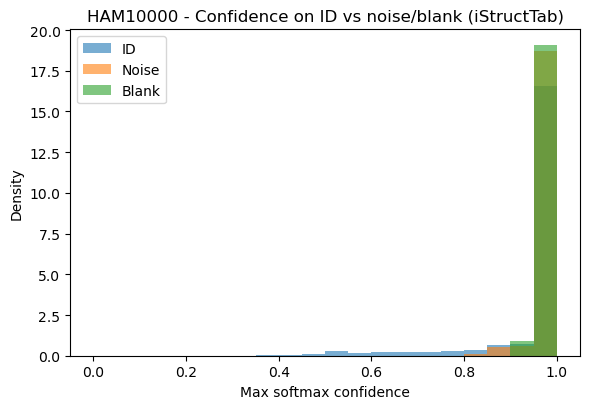

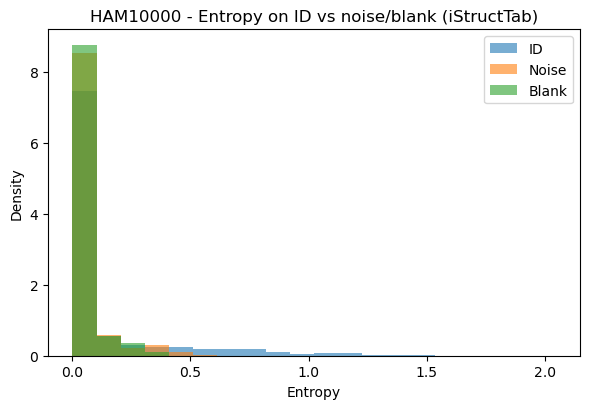

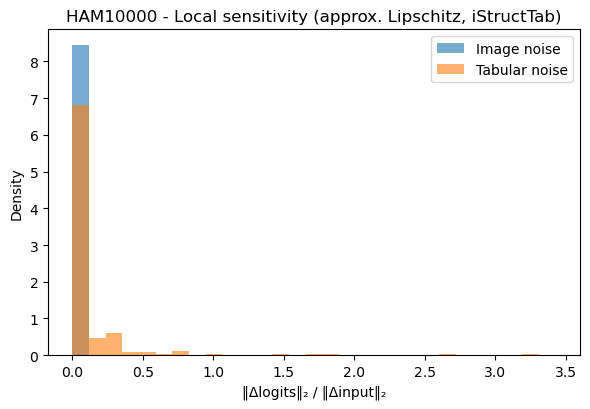

In [15]:
# ===================== OOD + sensitivity diagnostics (HAM10000, iStructTab) =====================
import numpy as np
import torch
import matplotlib.pyplot as plt
from pathlib import Path

plt.rcParams.update({"savefig.facecolor": "white", "figure.facecolor": "white"})

# ---- Use iStructTab HAM model + test loader ----
model  = model_best.eval()
loader = dl_test_best
device = next(model.parameters()).device
print(f"[INFO] OOD + sensitivity diagnostics with iStructTab on device={device}")

# ---------- 0. ID baseline stats (reuse predict_loader) ----------
logits_id, probs_id, preds_id, y_id, embs_id = predict_loader(loader, perturb=None)
probs_id = np.asarray(probs_id)
y_id     = np.asarray(y_id)
preds_id = np.asarray(preds_id)

maxconf_id = probs_id.max(axis=1)
entropy_id = -(probs_id * np.log(probs_id + 1e-12)).sum(axis=1)

print(f"[ID] N={len(y_id)}, accuracy={ (preds_id==y_id).mean()*100:.2f}%")
print(f"[ID] mean(max_conf)={maxconf_id.mean():.3f}, mean(entropy)={entropy_id.mean():.3f}")

# ---------- 1. Build noise / garbage inputs ----------
# We iterate once through loader and build three sets:
#   - ID (already have)
#   - Noise images + random tabular
#   - Blank images + random tabular

ximgs_list = []
xtab_num_list = []
xtab_cat_list = []
xtab_text_list = []

for x_tab, x_img, y in loader:
    x_img = x_img.to(device)
    ximgs_list.append(x_img.cpu())

    # x_tab structure: {"num": [B, n_num], "cat": [B, n_cat], "text": [B, 1, 1]}
    num  = x_tab["num"]
    cat  = x_tab["cat"]
    text = x_tab["text"]
    xtab_num_list.append(num.cpu())
    xtab_cat_list.append(cat.cpu())
    xtab_text_list.append(text.cpu())

ximgs     = torch.cat(ximgs_list, dim=0)          # [N, C, H, W]
xtab_num  = torch.cat(xtab_num_list, dim=0)       # [N, n_num]
xtab_cat  = torch.cat(xtab_cat_list, dim=0)       # [N, n_cat]
xtab_text = torch.cat(xtab_text_list, dim=0)      # [N, 1, 1] dummy text channel

N, C, H, W = ximgs.shape
print(f"[Data] Images shape: {ximgs.shape}, num tab: {xtab_num.shape[1]}, cat tab: {xtab_cat.shape[1]}")

# Helper: wrap into mini-batches and run model
@torch.no_grad()
def _run_on_arrays(ximgs_arr, xtab_num_arr, xtab_cat_arr, xtab_text_arr, batch_size=64):
    probs_all = []
    N_local = ximgs_arr.shape[0]
    for i in range(0, N_local, batch_size):
        sl = slice(i, min(i+batch_size, N_local))
        x_img = ximgs_arr[sl].to(device)
        x_tab = {
            "num":  xtab_num_arr[sl].to(device),
            "cat":  xtab_cat_arr[sl].to(device),
            "text": xtab_text_arr[sl].to(device),
        }
        out = model(x_tab, x_img)
        probs = torch.softmax(out["logits"], dim=1)
        probs_all.append(probs.cpu())
    probs_all = torch.cat(probs_all, dim=0).numpy()
    maxconf = probs_all.max(axis=1)
    entropy = -(probs_all * np.log(probs_all + 1e-12)).sum(axis=1)
    return probs_all, maxconf, entropy

# 1a) Noise images + random tabular
torch.manual_seed(0)
noise_imgs = torch.randn_like(ximgs)  # standard normal, same shape as normalized images

# Random tabular: shuffle each column independently (num & cat), keep text as-is
rand_num  = xtab_num.clone()
rand_cat  = xtab_cat.clone()
rand_text = xtab_text.clone()  # text is dummy; no need to shuffle

for j in range(rand_num.shape[1]):
    perm = torch.randperm(N)
    rand_num[:, j] = rand_num[perm, j]
for j in range(rand_cat.shape[1]):
    perm = torch.randperm(N)
    rand_cat[:, j] = rand_cat[perm, j]

probs_noise, maxconf_noise, entropy_noise = _run_on_arrays(noise_imgs, rand_num, rand_cat, rand_text)
print(f"[Noise] mean(max_conf)={maxconf_noise.mean():.3f}, mean(entropy)={entropy_noise.mean():.3f}")

# 1b) Blank images + random tabular (different seed)
torch.manual_seed(1)
blank_imgs = torch.zeros_like(ximgs) + 0.5  # uniform gray (still in normalized-ish space)

rand_num2  = xtab_num.clone()
rand_cat2  = xtab_cat.clone()
rand_text2 = xtab_text.clone()

for j in range(rand_num2.shape[1]):
    perm = torch.randperm(N)
    rand_num2[:, j] = rand_num2[perm, j]
for j in range(rand_cat2.shape[1]):
    perm = torch.randperm(N)
    rand_cat2[:, j] = rand_cat2[perm, j]

probs_blank, maxconf_blank, entropy_blank = _run_on_arrays(blank_imgs, rand_num2, rand_cat2, rand_text2)
print(f"[Blank] mean(max_conf)={maxconf_blank.mean():.3f}, mean(entropy)={entropy_blank.mean():.3f}")

# ---------- 2. Confidence & entropy histograms ----------
bins_conf = np.linspace(0.0, 1.0, 21)

plt.figure(figsize=(6.0, 4.2))
plt.hist(maxconf_id,     bins=bins_conf, alpha=0.6, label="ID",    density=True)
plt.hist(maxconf_noise,  bins=bins_conf, alpha=0.6, label="Noise", density=True)
plt.hist(maxconf_blank,  bins=bins_conf, alpha=0.6, label="Blank", density=True)
plt.xlabel("Max softmax confidence")
plt.ylabel("Density")
plt.title("HAM10000 - Confidence on ID vs noise/blank (iStructTab)")
plt.legend()
plt.tight_layout()
plt.savefig("ham_istructtab_conf_id_vs_noise_blank.png", dpi=600, bbox_inches="tight")

bins_ent = np.linspace(0.0, np.log(probs_id.shape[1])+0.1, 21)

plt.figure(figsize=(6.0, 4.2))
plt.hist(entropy_id,     bins=bins_ent, alpha=0.6, label="ID",    density=True)
plt.hist(entropy_noise,  bins=bins_ent, alpha=0.6, label="Noise", density=True)
plt.hist(entropy_blank,  bins=bins_ent, alpha=0.6, label="Blank", density=True)
plt.xlabel("Entropy")
plt.ylabel("Density")
plt.title("HAM10000 - Entropy on ID vs noise/blank (iStructTab)")
plt.legend()
plt.tight_layout()
plt.savefig("ham_istructtab_entropy_id_vs_noise_blank.png", dpi=600, bbox_inches="tight")

# ---------- 3. Local sensitivity (Lipschitz-ish) ----------
@torch.no_grad()
def local_sensitivity_image(xtab_num, xtab_cat, xtab_text, ximgs, eps=0.01, n_samples=200, batch_size=32):
    idx = np.random.choice(ximgs.shape[0], size=min(n_samples, ximgs.shape[0]), replace=False)
    ratios = []
    for start in range(0, len(idx), batch_size):
        sl_idx = idx[start:start+batch_size]
        if len(sl_idx) == 0:
            break
        x_img = ximgs[sl_idx].to(device)
        x_tab = {
            "num":  xtab_num[sl_idx].to(device),
            "cat":  xtab_cat[sl_idx].to(device),
            "text": xtab_text[sl_idx].to(device),
        }

        out_base = model(x_tab, x_img)["logits"]

        noise = torch.randn_like(x_img)
        noise_flat = noise.view(noise.size(0), -1)
        norm = torch.norm(noise_flat, dim=1, keepdim=True) + 1e-12
        noise = noise / norm.view(noise.size(0), 1, 1, 1) * eps
        x_img_pert = x_img + noise  # keep in normalized space; no clamp

        out_pert = model(x_tab, x_img_pert)["logits"]

        diff = out_pert - out_base
        diff_norm = diff.view(diff.size(0), -1).norm(dim=1)
        inp_norm = noise_flat.norm(dim=1)  # ~eps * sqrt(C*H*W)
        ratios.extend((diff_norm / (inp_norm + 1e-12)).cpu().numpy())
    return np.array(ratios)

@torch.no_grad()
def local_sensitivity_tabular(xtab_num, xtab_cat, xtab_text, ximgs, eps=0.1, n_samples=200, batch_size=32):
    idx = np.random.choice(ximgs.shape[0], size=min(n_samples, ximgs.shape[0]), replace=False)
    ratios = []
    for start in range(0, len(idx), batch_size):
        sl_idx = idx[start:start+batch_size]
        if len(sl_idx) == 0:
            break
        x_img = ximgs[sl_idx].to(device)
        num   = xtab_num[sl_idx].to(device)
        cat   = xtab_cat[sl_idx].to(device)
        text  = xtab_text[sl_idx].to(device)

        out_base = model({"num": num, "cat": cat, "text": text}, x_img)["logits"]

        if num.numel() == 0:
            # no numeric features -> skip numeric perturbation
            continue

        noise = torch.randn_like(num)
        noise_flat = noise.view(noise.size(0), -1)
        norm = torch.norm(noise_flat, dim=1, keepdim=True) + 1e-12
        noise = noise / norm * eps
        num_pert = num + noise

        out_pert = model({"num": num_pert, "cat": cat, "text": text}, x_img)["logits"]

        diff = out_pert - out_base
        diff_norm = diff.view(diff.size(0), -1).norm(dim=1)
        inp_norm = noise_flat.norm(dim=1)
        ratios.extend((diff_norm / (inp_norm + 1e-12)).cpu().numpy())
    return np.array(ratios)

sens_img = local_sensitivity_image(xtab_num, xtab_cat, xtab_text, ximgs, eps=0.01, n_samples=200)
sens_tab = local_sensitivity_tabular(xtab_num, xtab_cat, xtab_text, ximgs, eps=0.10, n_samples=200)

print(f"\n[Local sensitivity] image eps=0.01, mean ratio={sens_img.mean():.3f}, median={np.median(sens_img):.3f}")
if sens_tab.size > 0:
    print(f"[Local sensitivity] tab   eps=0.10, mean ratio={sens_tab.mean():.3f}, median={np.median(sens_tab):.3f}")
else:
    print("[Local sensitivity] tab   eps=0.10: skipped (no numeric features).")

plt.figure(figsize=(6.0, 4.2))
max_val = max(sens_img.max(), sens_tab.max() if sens_tab.size > 0 else sens_img.max())
bins_s = np.linspace(0.0, max_val * 1.05, 30)
plt.hist(sens_img, bins=bins_s, alpha=0.6, label="Image noise", density=True)
if sens_tab.size > 0:
    plt.hist(sens_tab, bins=bins_s, alpha=0.6, label="Tabular noise", density=True)
plt.xlabel("‖Δlogits‖₂ / ‖Δinput‖₂")
plt.ylabel("Density")
plt.title("HAM10000 - Local sensitivity (approx. Lipschitz, iStructTab)")
plt.legend()
plt.tight_layout()
plt.savefig("ham_istructtab_local_sensitivity_img_vs_tab.png", dpi=600, bbox_inches="tight")

print("\n[Done] OOD + sensitivity diagnostics (iStructTab) complete.")
print("Saved figures:")
print("  - ham_istructtab_conf_id_vs_noise_blank.png")
print("  - ham_istructtab_entropy_id_vs_noise_blank.png")
print("  - ham_istructtab_local_sensitivity_img_vs_tab.png")

# Deployment-Oriented Triage Diagnostics

[INFO] Deployment-style diagnostics with iStructTab on device=cuda:2
[Info] N=2003, num_classes=7
[Triage] Using malignant class IDs: [0, 1, 4]

[Triage] Binary (malignant vs benign) AUC = 0.936
[Triage] Chosen threshold th* = 0.0030 with sensitivity=0.950, specificity=0.705

[Triage] Confusion matrix at th* (rows=true, cols=pred):
          pred=benign   pred=malignant
true=benign     1142            478
true=malig        19            364

[Triage] Acc=75.19%, Prec=43.23%, Recall=95.04%

[Fairness] Unique sex values: ['female' 'male' 'unknown']

[Fairness] Sex slices (on triage task, iStructTab)
[Fairness] sex=female: n=868, Acc=75.69%, Sens=92.06%, Spec=72.91%
[Fairness] sex=male: n=1127, Acc=74.89%, Sens=96.50%, Spec=68.51%
[Fairness] sex=unknown: n=8, Acc=62.50%, Sens=0.00%, Spec=62.50%

[Fairness] Age slices (on triage task, iStructTab)
[Fairness] age_bucket=40-59: n=889, Acc=80.20%, Sens=91.00%, Spec=78.83%
[Fairness] age_bucket=60-79: n=594, Acc=67.17%, Sens=97.44%, Spec=52.38%

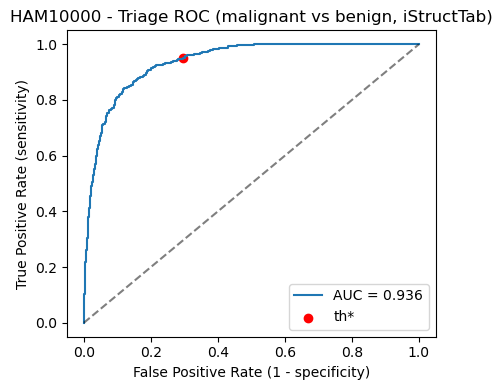

In [16]:
# ============== Deployment-style diagnostics: triage & fairness (HAM10000, iStructTab) ==============
import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import (
    roc_curve, auc, confusion_matrix,
    accuracy_score, precision_score, recall_score
)

plt.rcParams.update({"savefig.facecolor": "white", "figure.facecolor": "white"})

# Use iStructTab HAM model + test loader
model  = model_best.eval()
loader = dl_test_best
device = next(model.parameters()).device
print(f"[INFO] Deployment-style diagnostics with iStructTab on device={device}")

# Helper (in case _to_device wasn't defined in this notebook)
def _to_device(x_tab, x_img, y=None, dev=device):
    x_tab = {k: v.to(dev) for k, v in x_tab.items()}
    x_img = x_img.to(dev)
    if y is not None:
        y = y.to(dev)
    return x_tab, x_img, y

# ------------------------------------------------------------------
# 0) Recompute predictions on the CURRENT loader so shapes match
# ------------------------------------------------------------------
logits, probs, preds, y, embs = predict_loader(loader, perturb=None)

logits = np.asarray(logits)
probs  = np.asarray(probs)
preds  = np.asarray(preds)
y      = np.asarray(y)

num_classes = probs.shape[1]
N = len(y)
print(f"[Info] N={N}, num_classes={num_classes}")

# ------------------------------------------------------------------
# 1) Define malignant vs benign mapping for triage
# ------------------------------------------------------------------
# Try to auto-detect malignant class IDs from HAM labels if available.
# For HAM10000, common malignant diagnoses: akiec, bcc, mel
import torch.utils.data as tud

base_ds = loader.dataset
if isinstance(base_ds, tud.Subset):
    base_ds = base_ds.dataset

class_names = getattr(base_ds, "classes", None)
MALIGNANT_CLASS_IDS = None

if class_names is not None:
    malignant_names = {"akiec", "bcc", "mel", "melanoma"}
    MALIGNANT_CLASS_IDS = [
        i for i, c in enumerate(class_names)
        if str(c).lower() in malignant_names
    ]
    if not MALIGNANT_CLASS_IDS:
        print("[Triage] WARNING: Could not infer malignant classes from names; defaulting to [0].")
        MALIGNANT_CLASS_IDS = [0]
else:
    print("[Triage] WARNING: No `classes` attribute on dataset; defaulting malignant IDs to [0].")
    MALIGNANT_CLASS_IDS = [0]

print(f"[Triage] Using malignant class IDs: {MALIGNANT_CLASS_IDS}")

malig_mask = np.isin(y, MALIGNANT_CLASS_IDS)
y_bin = malig_mask.astype(int)  # 1 = malignant, 0 = benign

# probability of "any malignant" = sum of probabilities over malignant classes
malig_prob = probs[:, MALIGNANT_CLASS_IDS].sum(axis=1)

# Sanity check: lengths must match
assert len(y_bin) == len(malig_prob), (
    f"Length mismatch: y_bin={len(y_bin)}, malig_prob={len(malig_prob)}"
)

# Handle degenerate case: only one class in this subset
if np.unique(y_bin).size < 2:
    print("\n[Triage] Warning: this subset has only one binary class "
          "(all benign or all malignant). ROC/AUC is undefined.")
    print("         Use a larger or more balanced test loader for triage analysis.")
else:
    # Basic ROC / AUC
    fpr, tpr, ths = roc_curve(y_bin, malig_prob)
    roc_auc = auc(fpr, tpr)
    print(f"\n[Triage] Binary (malignant vs benign) AUC = {roc_auc:.3f}")

    # Pick a threshold that achieves target sensitivity (e.g., 95%)
    TARGET_SENS = 0.95
    sens = tpr
    spec = 1 - fpr

    valid_idx = np.where(sens >= TARGET_SENS)[0]
    if len(valid_idx) == 0:
        print(f"[Triage] No threshold achieves sensitivity ≥ {TARGET_SENS:.2f}")
        best_idx = np.argmax(sens)  # highest sensitivity anyway
    else:
        # Among thresholds with desired sensitivity, pick one with highest specificity
        best_idx = valid_idx[np.argmax(spec[valid_idx])]

    th_star = ths[best_idx]
    sens_star = sens[best_idx]
    spec_star = spec[best_idx]
    print(f"[Triage] Chosen threshold th* = {th_star:.4f} "
          f"with sensitivity={sens_star:.3f}, specificity={spec_star:.3f}")

    # Confusion matrix at th*
    y_hat_bin = (malig_prob >= th_star).astype(int)
    cm = confusion_matrix(y_bin, y_hat_bin, labels=[0, 1])
    tn, fp, fn, tp = cm.ravel()
    print("\n[Triage] Confusion matrix at th* (rows=true, cols=pred):")
    print("          pred=benign   pred=malignant")
    print(f"true=benign   {tn:6d}         {fp:6d}")
    print(f"true=malig    {fn:6d}         {tp:6d}")

    def bin_metrics(y_true, y_pred):
        acc  = accuracy_score(y_true, y_pred)
        prec = precision_score(y_true, y_pred, zero_division=0)
        rec  = recall_score(y_true, y_pred, zero_division=0)
        return acc, prec, rec

    acc_star, prec_star, rec_star = bin_metrics(y_bin, y_hat_bin)
    print(f"\n[Triage] Acc={acc_star*100:.2f}%, Prec={prec_star*100:.2f}%, "
          f"Recall={rec_star*100:.2f}%")

    # ROC plot
    plt.figure(figsize=(4.5, 4.0))
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
    plt.plot([0, 1], [0, 1], "k--", alpha=0.5)
    plt.scatter(fpr[best_idx], tpr[best_idx], c="red", label="th*")
    plt.xlabel("False Positive Rate (1 - specificity)")
    plt.ylabel("True Positive Rate (sensitivity)")
    plt.title("HAM10000 - Triage ROC (malignant vs benign, iStructTab)")
    plt.legend()
    plt.tight_layout()
    plt.savefig("ham_istructtab_triage_roc.png", dpi=600, bbox_inches="tight")

# ------------------------------------------------------------------
# 2) Fairness slices: sex + age buckets (aligned with test subset)
# ------------------------------------------------------------------
dataset = loader.dataset

# Map through Subset -> base dataset and align indices
if isinstance(dataset, tud.Subset):
    base_ds = dataset.dataset
    idxs    = dataset.indices
else:
    base_ds = dataset
    idxs    = np.arange(len(dataset))

sex_arr = None
age_arr = None

try:
    if hasattr(base_ds, "df") and isinstance(base_ds.df, pd.DataFrame):
        sex_arr_full = base_ds.df["sex"].to_numpy()
        age_arr_full = base_ds.df["age"].to_numpy()
        sex_arr = sex_arr_full[idxs]
        age_arr = age_arr_full[idxs]
    elif hasattr(base_ds, "meta") and isinstance(base_ds.meta, pd.DataFrame):
        sex_arr_full = base_ds.meta["sex"].to_numpy()
        age_arr_full = base_ds.meta["age"].to_numpy()
        sex_arr = sex_arr_full[idxs]
        age_arr = age_arr_full[idxs]
except Exception as e:
    print("\n[Fairness] Error while trying to fetch sex/age:", e)

if sex_arr is None or age_arr is None:
    print("\n[Fairness] Could not automatically fetch sex/age metadata.")
    print("           Skipping fairness analysis for now.")
else:
    sex_arr = np.asarray(sex_arr)
    age_arr = np.asarray(age_arr)

    print("\n[Fairness] Unique sex values:", np.unique(sex_arr))

    def age_bucket(a):
        try:
            a = float(a)
        except Exception:
            return "unknown"
        if np.isnan(a):
            return "unknown"
        if a < 40:
            return "<40"
        elif a < 60:
            return "40-59"
        elif a < 80:
            return "60-79"
        else:
            return "80+"

    age_buckets = np.array([age_bucket(a) for a in age_arr])

    def show_slice_metrics(mask, name):
        if mask.sum() == 0:
            print(f"[Fairness] {name}: no samples.")
            return
        y_true_bin = y_bin[mask]
        # If y_hat_bin exists (ROC ran), use that; else default to threshold 0.5
        if "y_hat_bin" in globals():
            y_pred_bin = y_hat_bin[mask]
        else:
            y_pred_bin = (malig_prob[mask] >= 0.5).astype(int)

        cm = confusion_matrix(y_true_bin, y_pred_bin, labels=[0, 1])
        tn, fp, fn, tp = cm.ravel()
        sens = tp / (tp + fn + 1e-12)
        spec = tn / (tn + fp + 1e-12)
        acc  = accuracy_score(y_true_bin, y_pred_bin)
        print(f"[Fairness] {name}: n={mask.sum()}, "
              f"Acc={acc*100:.2f}%, Sens={sens*100:.2f}%, Spec={spec*100:.2f}%")

    print("\n[Fairness] Sex slices (on triage task, iStructTab)")
    for v in np.unique(sex_arr):
        m = sex_arr == v
        show_slice_metrics(m, f"sex={v}")

    print("\n[Fairness] Age slices (on triage task, iStructTab)")
    for b in np.unique(age_buckets):
        m = age_buckets == b
        show_slice_metrics(m, f"age_bucket={b}")

# ------------------------------------------------------------------
# 3) Simple reliability: latency stats on this hardware
# ------------------------------------------------------------------
import time

def measure_latency(loader, num_batches=10):
    times = []
    with torch.no_grad():
        for bi, (x_tab, x_img, y_batch) in enumerate(loader):
            if bi >= num_batches:
                break
            x_tab, x_img, _ = _to_device(x_tab, x_img, None, dev=device)
            if device.type == "cuda":
                torch.cuda.synchronize(device)
            t0 = time.time()
            out = model(x_tab, x_img)
            _ = out["logits"]
            if device.type == "cuda":
                torch.cuda.synchronize(device)
            t1 = time.time()
            times.append(t1 - t0)
    return np.array(times)

lat = measure_latency(loader, num_batches=20)
if len(lat) > 0:
    print("\n[Reliability] Latency stats over 20 batches (iStructTab):")
    print(f"  mean = {lat.mean()*1000:.2f} ms/batch")
    print(f"  p50  = {np.percentile(lat, 50)*1000:.2f} ms/batch")
    print(f"  p90  = {np.percentile(lat, 90)*1000:.2f} ms/batch")
    print(f"  p99  = {np.percentile(lat, 99)*1000:.2f} ms/batch")
else:
    print("\n[Reliability] Not enough batches for latency measurement.")

print("\n[Done] Deployment-style diagnostics (triage + fairness + latency, iStructTab) complete.")
print("If ROC ran, saved: ham_istructtab_triage_roc.png")